In [1]:
# Uncomment and run

# !pip install git+https://github.com/i-a-morozov/python-nufft.git
# !pip install pyepics
# !git clone https://github.com/i-a-morozov/2311.14287
# %cd 2311.14287

In [2]:
# Import

import numpy
import torch
import pandas

from src.util import mod
from src.window import Window
from src.data import Data
from src.frequency import Frequency
from src.filter import Filter
from src.decomposition import Decomposition
from src.model import Model
from src.table import Table
from src.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)

In [3]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [4]:
# Global

SAVE:bool  = False  # -- flag to save figs
N_JOBS:int = 2      # -- number of jobs

# Ratio minimization (spectra)

In [5]:
# Set model with errors

model = Model(path='base.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 1.0E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 16384, 4])

4.842982430e-07, 1.166020776e-17
1.526720460e-07, 1.903110712e-18



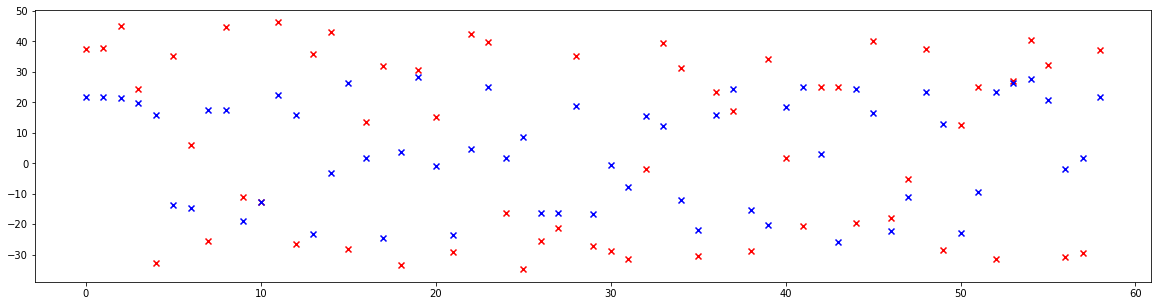

tensor(1.384680833198e+02, dtype=torch.float64)
tensor(1.344644247823e+02, dtype=torch.float64)



In [6]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**14

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from src.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from src.parameterization import normal_to_wolski
from src.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

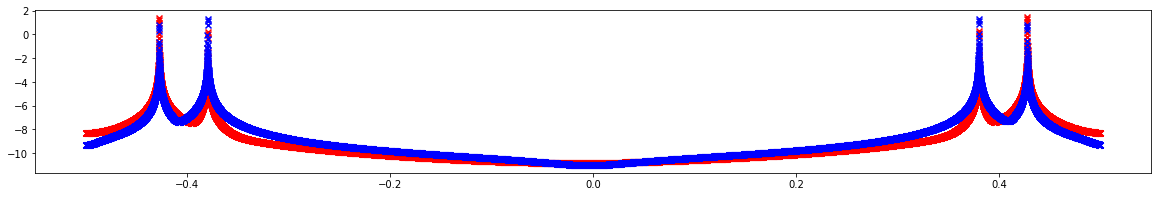

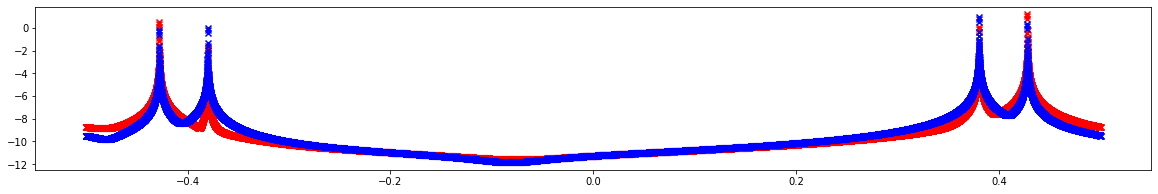

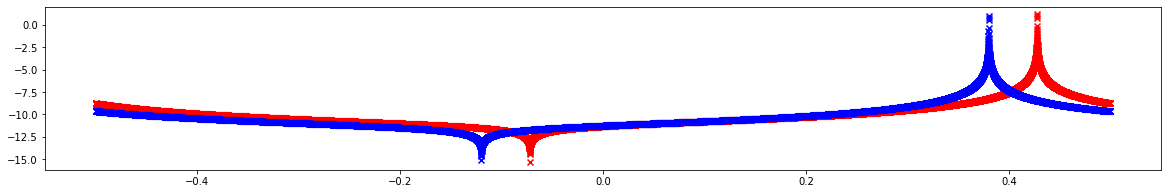

In [7]:
# For coupled case, each spectrum contains four peaks
# Main peak (nux or nuy in x or y), main mirror peak (-nux or -nuy in x or y)
# Coupling peak (nux or nuy in  in y or x), coupling mirror peak (-nux or -nuy in  in y or x)

window = Window.cosine_window(length, 1.0, dtype=dtype)

index = 0
orbit = trajectory[index].T
qx, px, qy, py = orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Floquet coordinates contain only one main peak (if normalization is correct)

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

In [8]:
# Instead of using FFT spectrum peak amplitudes, one can compute DTFT amplitudes for given four frequencies

# Fractional tunes

nux, nuy = mod(model.out_tune, 1)

# Mirror tunes

NUX, NUY = abs(mod(model.out_tune, 1, -0.5))

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()

# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()

[16.27434268  3.13980141  1.2568225   0.01749055]
[9.0213678  0.99959654 2.33105049 0.65117881]
0.7126086813456616

[1.61246904e+01 3.55833564e-10 6.85681280e-10 1.53766512e-10]
[9.05346235e+00 4.45434586e-11 3.85244984e-10 8.63136184e-11]
1.3113344165882217e-10



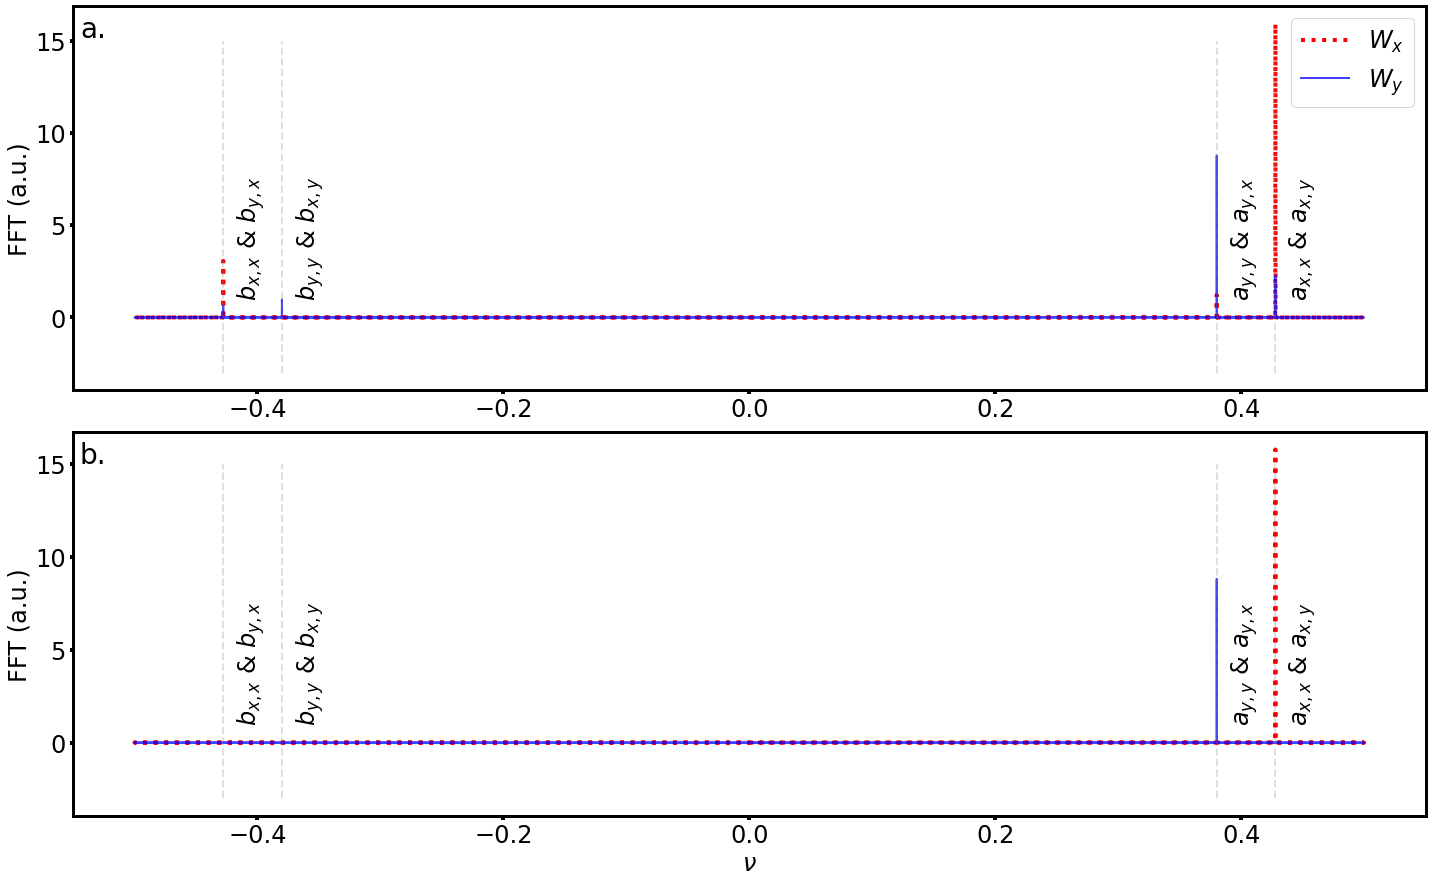

In [9]:
# FIG

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

# Use unmatched normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

ax = plt.subplot(211)
ax.plot(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().cpu().numpy(), color='red', linestyle="dotted", linewidth=4, label=r'$W_x$')
ax.plot(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().cpu().numpy(), color='blue', linewidth=2, alpha=0.75, label=r'$W_y$')
ax.set_ylabel(r'FFT (a.u.)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.vlines([NUX, NUY, -NUX, -NUY], -5*15/25, 15, alpha=0.25, linestyles='dashed', color='gray', linewidth=2)
ax.text(NUX.item() + 0.01, 1.5,  "$a_{x,x}~&~a_{x,y}$", rotation=90, fontsize=24)
ax.text(NUY.item() + 0.01, 1.5,  "$a_{y,y}~&~a_{y,x}$", rotation=90, fontsize=24)
ax.text(-NUX.item() + 0.01, 1.5, "$b_{x,x}~&~b_{y,x}$", rotation=90, fontsize=24)
ax.text(-NUY.item() + 0.01, 1.5, "$b_{y,y}~&~b_{x,y}$", rotation=90, fontsize=24)

ax.legend(loc=1, prop={'size': 24})

plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

# Use matched normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

ax = plt.subplot(212)
ax.plot(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().cpu().numpy(), color='red', linestyle="dotted", linewidth=4)
ax.plot(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().cpu().numpy(), color='blue', alpha=0.75, linewidth=2)
ax.set_xlabel(r'$\nu$', fontsize=24)
ax.set_ylabel(r'FFT (a.u.)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.vlines([NUX, NUY, -NUX, -NUY], -5*15/25, 15, alpha=0.25, linestyles='dashed', color='gray', linewidth=2)
ax.text(NUX.item() + 0.01, 1.5,  "$a_{x,x}~&~a_{x,y}$", rotation=90, fontsize=24)
ax.text(NUY.item() + 0.01, 1.5,  "$a_{y,y}~&~a_{y,x}$", rotation=90, fontsize=24)
ax.text(-NUX.item() + 0.01, 1.5, "$b_{x,x}~&~b_{y,x}$", rotation=90, fontsize=24)
ax.text(-NUY.item() + 0.01, 1.5, "$b_{y,y}~&~b_{x,y}$", rotation=90, fontsize=24)


plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig('02_spectra.png', dpi=300)

plt.show()

# Invariant fit (actions)

In [10]:
# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Using coordinates and momenta linear invariants are fitted
# Known invariant values can be passed, else both invariant values and twiss parameters are fitted
# Fit objective is ((jx(qx, px, qy, py; beta) - ix)**2 + (jy(qx, px, qy, py; beta) - iy)**2).sqrt()
# Or ((jx(qx, px, qy, py; beta) - ix)**2 * (jy(qx, px, qy, py; beta) - iy)**2).sqrt() (default)
# Where, for coupled case, beta = (n11, n33, n21, n43, n13, n31, n14, and n41) and ix & iy are invariant values (can be fixed on input or estimated)

# Fitting is performed using nonlinear least squares
# Note, fitting is bootstrapped (signals are randomly sampled with replacement)
# The result is returned for each sample (values and errors) at each monitor location (beta or beta and invariants)
# Processing (filtering and weighting) is then performed over samples for each monitor location
# Ones invariants are estimated, fit can be performed with fixed invariants (this can improve result quality in some cases)

# Here, random normal & skew thin quadrupole errors are introduced are twiss estimation is performed using amplitude & phase data
# These estimations are compared with fitted values

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [11]:
# Set model with errors

model = Model(path='base.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.5E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.466307897e-07, 1.230250369e-18
1.074134864e-07, 2.461895197e-19



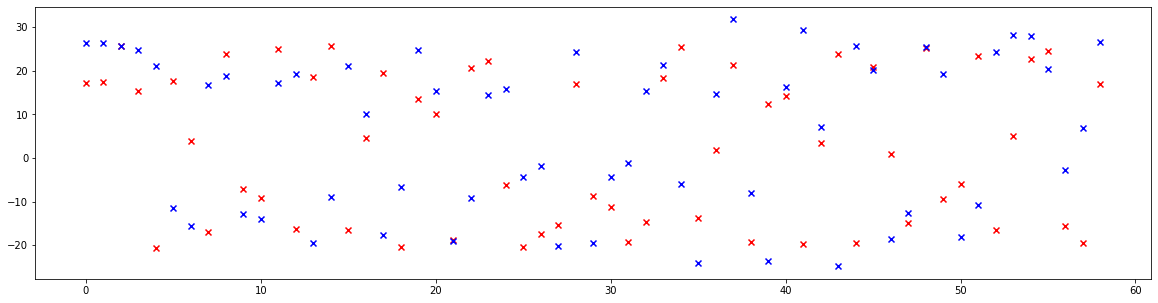

tensor(7.925556514956e+01, dtype=torch.float64)
tensor(1.412688432764e+02, dtype=torch.float64)



In [12]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from src.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from src.parameterization import normal_to_wolski
from src.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [13]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from src.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [14]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [15]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.570383927
nux= 0.570383948, sigma_nux=1.05680729e-07, error_nux=2.12795643e-08


In [16]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nux={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.609944951
nuy= 0.609944953, sigma_nuy=1.76319422e-07, error_nux=2.01619077e-09


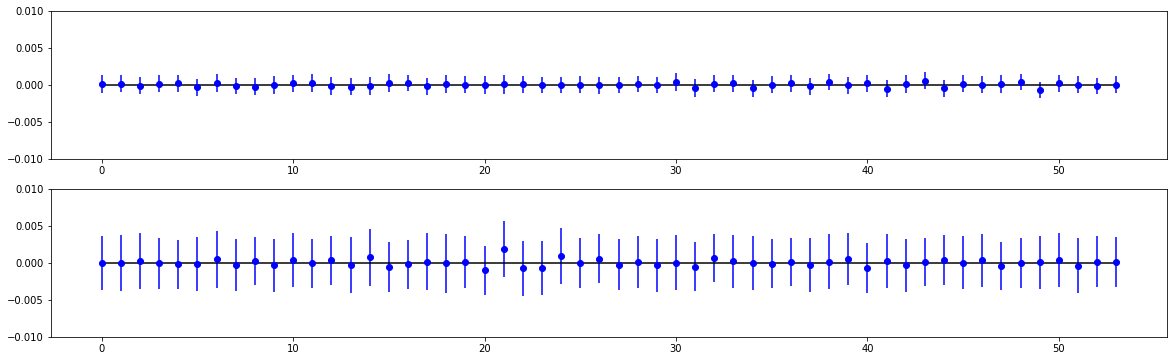

In [17]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

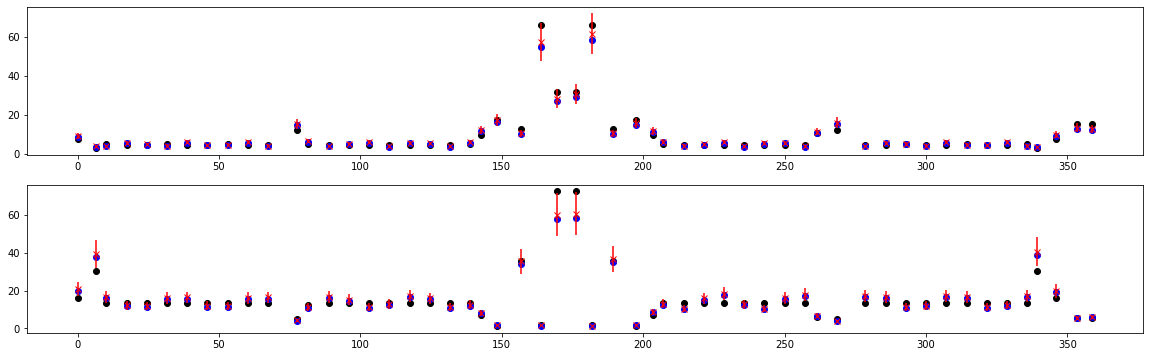

tensor(7.925556514956e+01, dtype=torch.float64)
tensor(2.492367363046e+01, dtype=torch.float64)

tensor(1.412688432764e+02, dtype=torch.float64)
tensor(3.265218855034e+01, dtype=torch.float64)



In [18]:
# Estimate twiss from amplitude

twiss = Twiss(model, table, limit=1)
twiss.get_action()
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_1 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_1 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print()

print(error_y)
print(error_y_1)
print()

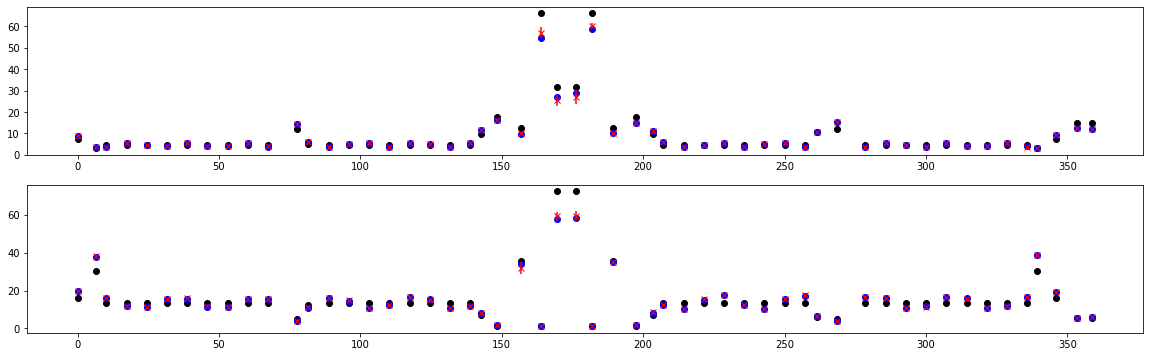

tensor(7.925556514956e+01, dtype=torch.float64)
tensor(2.492367363046e+01, dtype=torch.float64)
tensor(1.047996034879e+01, dtype=torch.float64)

tensor(1.412688432764e+02, dtype=torch.float64)
tensor(3.265218855034e+01, dtype=torch.float64)
tensor(1.037596937287e+01, dtype=torch.float64)



In [19]:
# Estimate twiss from phase

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_2 = (cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum()
error_y_2 = (cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print()

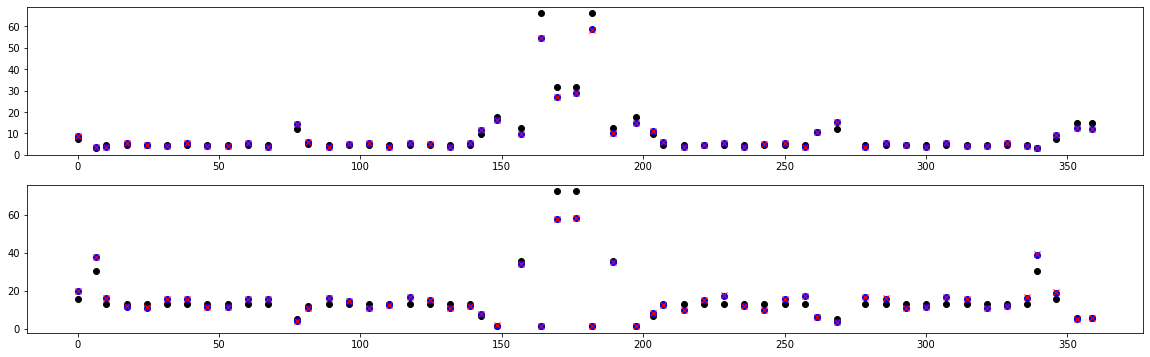

tensor(7.925556514956e+01, dtype=torch.float64)
tensor(2.492367363046e+01, dtype=torch.float64)
tensor(1.047996034879e+01, dtype=torch.float64)
tensor(5.173432081695e-01, dtype=torch.float64)

tensor(1.412688432764e+02, dtype=torch.float64)
tensor(3.265218855034e+01, dtype=torch.float64)
tensor(1.037596937287e+01, dtype=torch.float64)
tensor(3.051343694706e+00, dtype=torch.float64)



In [20]:
# Estimate twiss from amplitude (corrected action)

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_3 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_3 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print()

In [21]:
# Estimate twiss from invariant fit (use first 256 turns and 512 random samples)

from src.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,                # -- first turn
                                 256,              # -- total number of turns, orbits are computed for (start, start + total)
                                 parametric_normal,# -- normalization
                                 model.matrix,     # -- transport matrix generator
                                 twiss=None,       # -- initial twiss for each location or None (use model values)
                                 method='lstsq',   # -- momenta computation method
                                 limit=1,          # -- range limit or direction/shift
                                 product=True,     # -- flag to use product objective
                                 jacobian=False,   # -- flag to use objective jacobian
                                 count=512,        # -- number of samples
                                 fraction=0.75,    # -- sample length fraction
                                 ix=None,          # -- ix invariant value
                                 iy=None,          # -- iy invariant value  (both should present for fixed fit)
                                 n_jobs=N_JOBS,    # -- number of parallel jobs (loop over samples)
                                 verbose=False)    # -- verbose flag
print(data.shape)

torch.Size([54, 2, 10, 512])


In [22]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

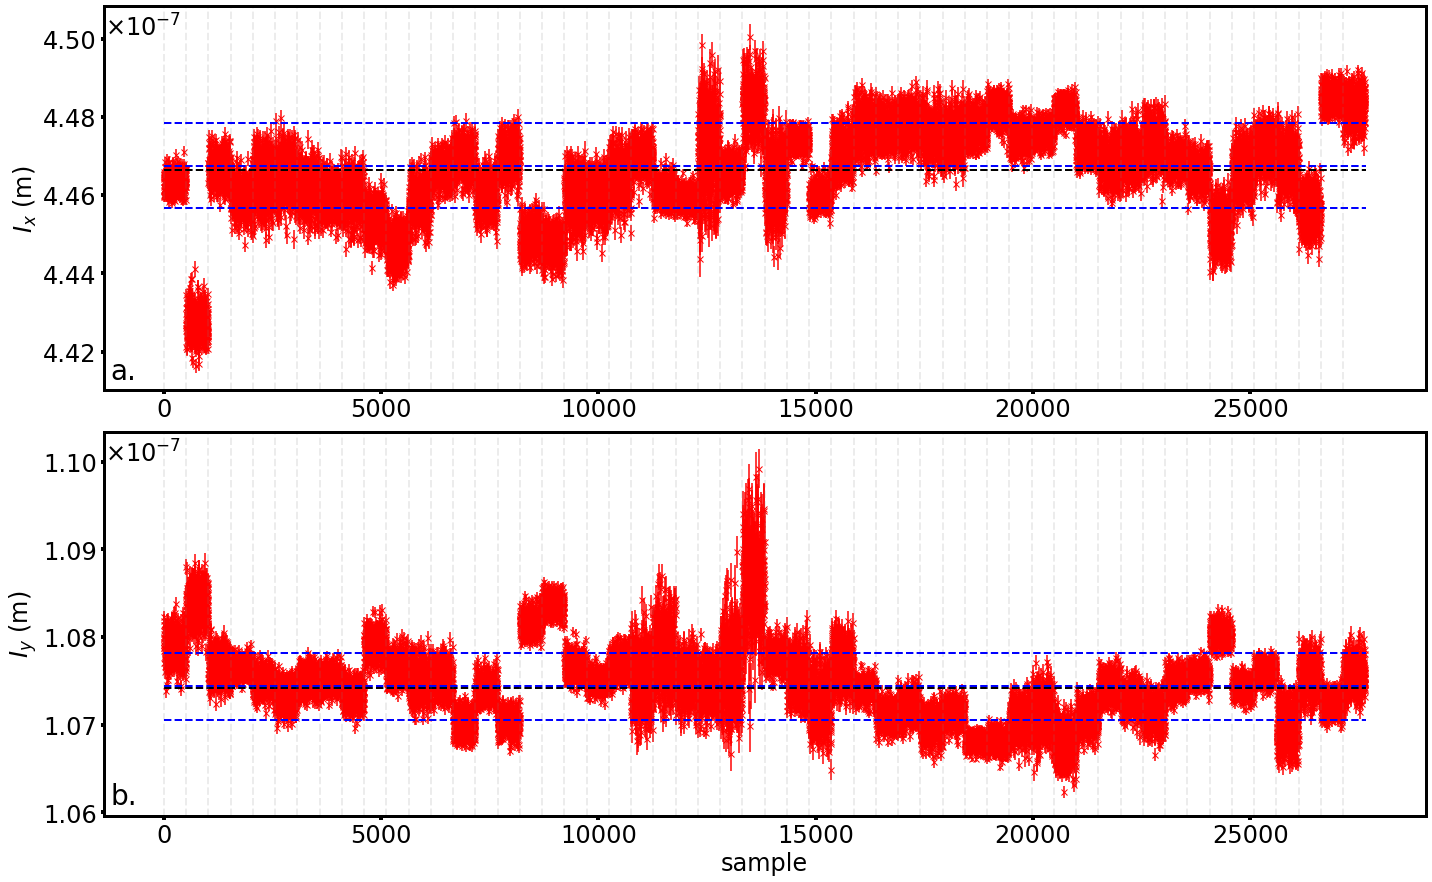

In [23]:
# FIG

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(range(54*512), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=1)
ax.hlines(action_x, 0, 54*512, linestyles='dashed', color='black',  zorder=2, linewidth=2)
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 512*54, linestyles='dashed', color='blue', zorder=3, linewidth=2)
ax.set_ylabel(r'$I_x$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.offsetText.set_visible(0)

mins = ix.min(-1).values
maxs = ix.max(-1).values

for ind in range(54):
    ax.axvline(512*ind-1, color='gray', alpha=0.15, linestyle='dashed', linewidth=2)

plt.text(0.03, 0.945, r'$\times 10^{-7}$', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)

plt.text(0.015, 0.05, 'a.', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(212)
ax.errorbar(range(54*512), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=1)
ax.hlines(action_y, 0, 54*512, linestyles='dashed', color='black',  zorder=2, linewidth=2)
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 512*54, linestyles='dashed', color='blue', zorder=3, linewidth=2)
ax.set_xlabel(r'sample', fontsize=24)
ax.set_ylabel(r'$I_y$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.offsetText.set_visible(0)

mins = iy.min(-1).values
maxs = iy.max(-1).values

for ind in range(54):
    ax.axvline(512*ind-1, color='gray', alpha=0.15, linestyle='dashed', linewidth=2)


plt.text(0.03, 0.945, r'$\times 10^{-7}$', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)

plt.text(0.015, 0.05, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig('03_sample.png', dpi=300)

plt.show()

# Coupled Twiss (VEPP-4M)

In [5]:
# Load model configuration

model = Model(path='vepp.yaml', dtype=dtype, device=device)
model.monitor_count
model.make_transport(error=False, exact=False)
model.make_twiss()
print(model.is_stable)

True


In [6]:
# Load signals

length = 1024

tbt_x = []
tbt_y = []

for name in model.name:
    index = model.get_index(name)
    start = model.rise[index]
    if name == 'NRP16':
        start += 1
    if model.is_monitor(index):
        x, y, _ = torch.tensor(numpy.loadtxt(f'tbt/01-n450-2000-10000-{name.lower()}.dat', delimiter=',')[start:start + length].T, dtype=dtype, device=device)
        tbt_x.append(x)
        tbt_y.append(y)

# Convert from [mm] to [m]
        
tbt_x = 1.0E-3*torch.stack(tbt_x)
tbt_y = 1.0E-3*torch.stack(tbt_y)

print(tbt_x.shape)
print(tbt_y.shape)

torch.Size([53, 1024])
torch.Size([53, 1024])


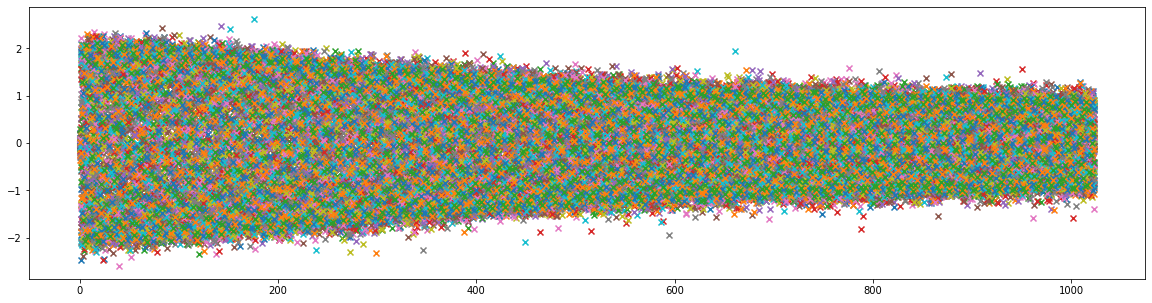

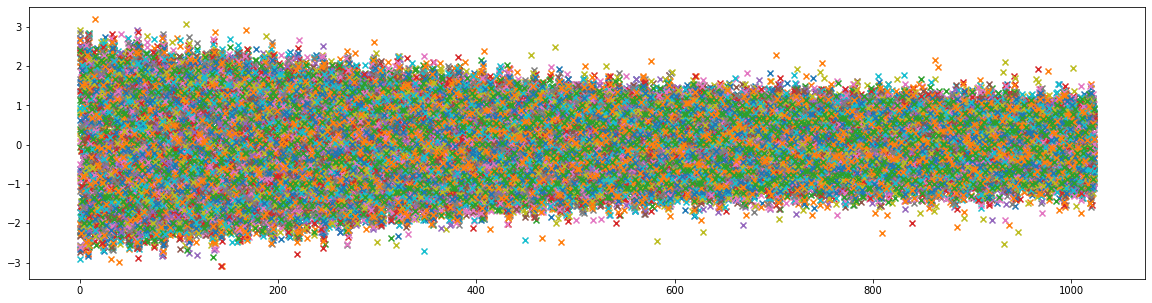

In [7]:
# Plot normalized signals

from src.statistics import standardize

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

signals = standardize(tbt_x)
plt.figure(figsize=(20, 5))
for signal in signals:
    plt.scatter(time, signal, marker='x')
plt.show()

signals = standardize(tbt_y)
plt.figure(figsize=(20, 5))
for signal in signals:
    plt.scatter(time, signal, marker='x')
plt.show()

In [8]:
# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, tbt_x)
X.window_remove_mean()
X.data.copy_(X.work)
print(X)

Y = Data.from_data(win, tbt_y)
Y.window_remove_mean()
Y.data.copy_(Y.work)
print(Y)

Data(53, Window(1024, 'cosine_window', 1.0))
Data(53, Window(1024, 'cosine_window', 1.0))


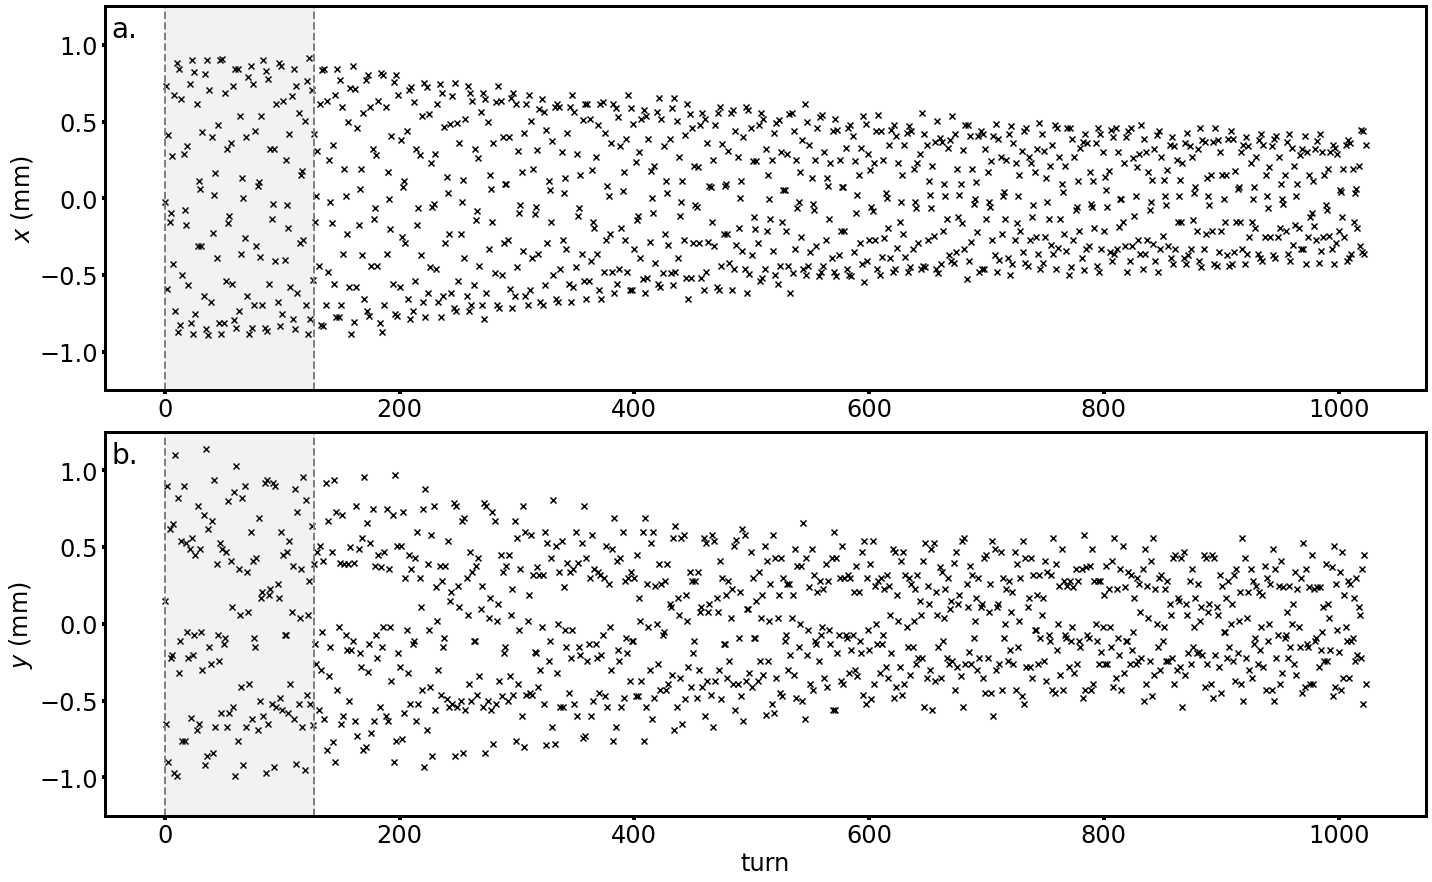

In [9]:
# FIG

index = 1
size = 1024

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(range(size), 1000*X.data[index, :size].cpu().numpy(), marker='x', color='black')
ax.set_ylabel(r'$x$ (mm)', fontsize=24)
ax.axvline(0, color='gray', linestyle='dashed', lw=2)
ax.axvline(128 - 1, color='gray', linestyle='dashed', lw=2)
ax.axvspan(0, 128-1, alpha=0.1, color='gray')
ax.tick_params(width=4, labelsize=24)
ax.set_ylim(-1.25, 1.25)

plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(212)
ax.scatter(range(size), 1000*Y.data[index, :size].cpu().numpy(), marker='x', color='black')
ax.set_ylabel(r'$y$ (mm)', fontsize=24)
ax.axvline(0, color='gray', linestyle='dashed', lw=2)
ax.axvline(128 - 1, color='gray', linestyle='dashed', lw=2)
ax.axvspan(0, 128-1, alpha=0.1, color='gray')
ax.tick_params(width=4, labelsize=24)
ax.set_xlabel(r'turn', fontsize=24)
ax.set_ylim(-1.25, 1.25)

plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("04_tbt.png", format="png", dpi=300)

plt.show()

nux= 0.540087715, sigma_nux=2.30055979e-06


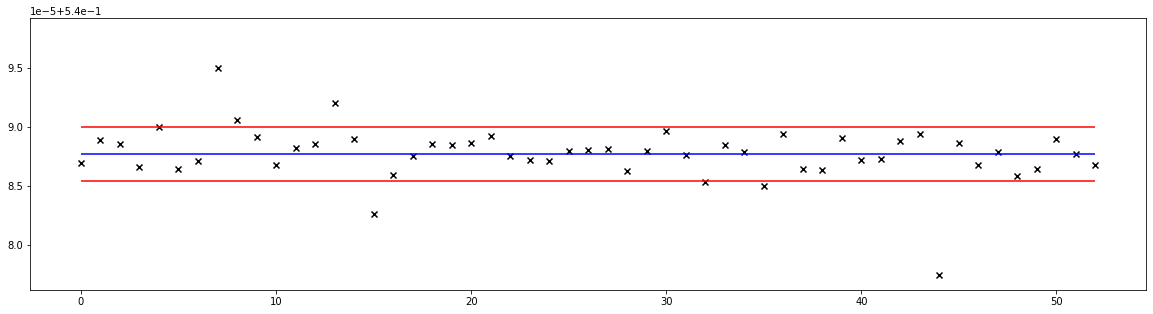

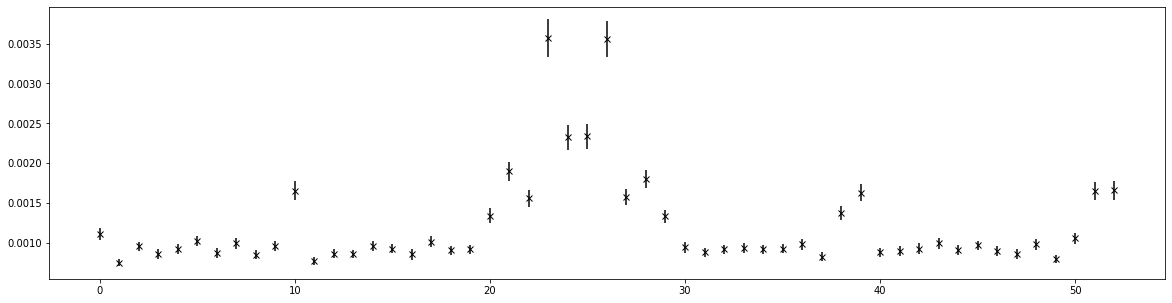

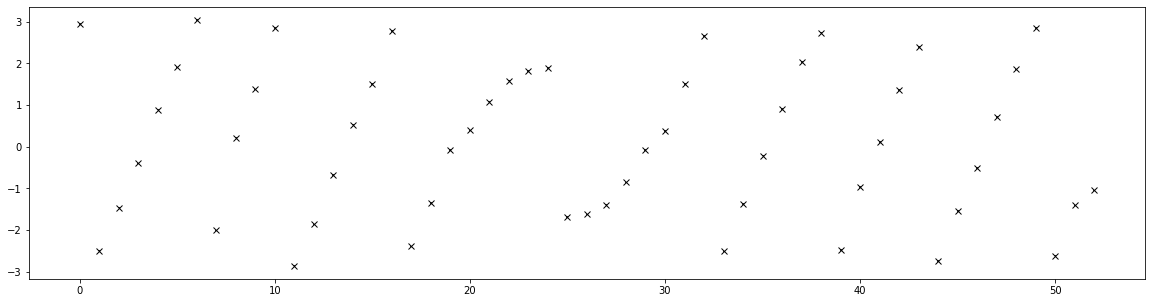

In [10]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

flt.filter_svd(rank=8, cpu=True)
flt.filter_hankel(rank=6, cpu=True, random=True, buffer=8, count=8)
X.window_remove_mean()
X.data.copy_(X.work)

# Estimate frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}')

# Plot frequency

plt.figure(figsize=(20, 5))
plt.scatter(range(model.monitor_count), 1.0 - f.frequency, color='black', marker='x')
plt.hlines(nux + sigma_nux, 0, model.monitor_count - 1, color='red')
plt.hlines(nux, 0, model.monitor_count - 1, color='blue')
plt.hlines(nux - sigma_nux, 0, model.monitor_count - 1, color='red')
plt.ylim(nux - 5.0*sigma_nux, nux + 5.0*sigma_nux)
plt.show()

# Estimate amplitude & phase

d = Decomposition(X)

axx, sigma_axx, _ = d.harmonic_amplitude(nux, length=128, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=4, method='noise')
fxx, sigma_fxx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=4, method='noise')

# Plot amplitude and phase

plt.figure(figsize=(20, 5))
plt.errorbar(range(model.monitor_count), axx, yerr=sigma_axx, color='black', marker='x', fmt=' ')
plt.show()

plt.figure(figsize=(20, 5))
plt.errorbar(range(model.monitor_count), fxx, yerr=sigma_fxx, color='black', marker='x', fmt=' ')
plt.show()

nuy= 0.577467517, sigma_nuy=2.76538117e-06


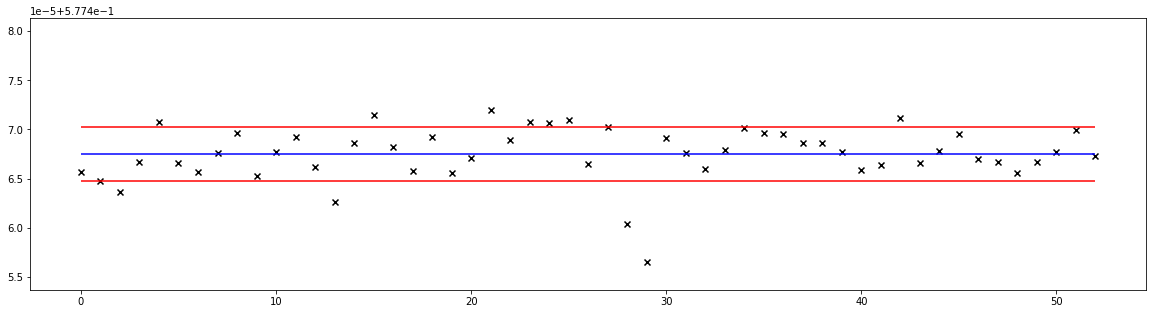

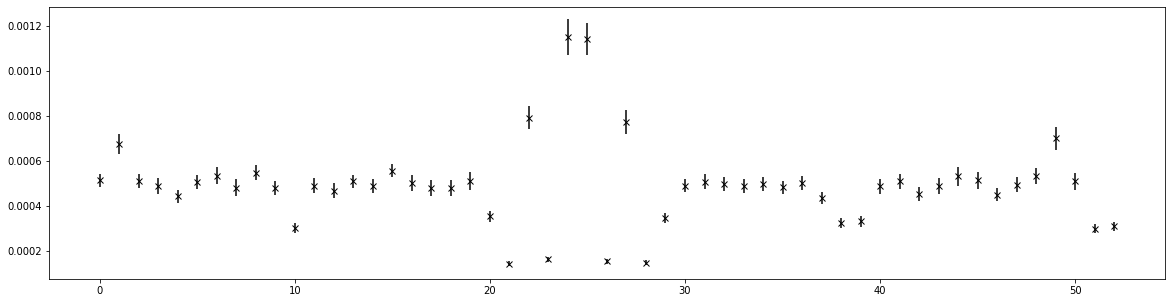

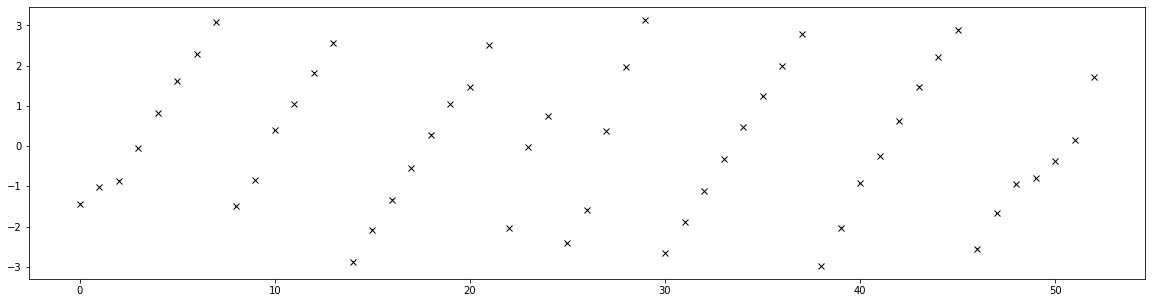

In [11]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

flt.filter_svd(rank=8, cpu=True)
flt.filter_hankel(rank=6, cpu=True, random=True, buffer=8, count=8)
Y.window_remove_mean()
Y.data.copy_(Y.work)

# Estimate frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}')

# Plot frequency

plt.figure(figsize=(20, 5))
plt.scatter(range(model.monitor_count), 1.0 - f.frequency, color='black', marker='x')
plt.hlines(nuy + sigma_nuy, 0, model.monitor_count - 1, color='red')
plt.hlines(nuy, 0, model.monitor_count - 1, color='blue')
plt.hlines(nuy - sigma_nuy, 0, model.monitor_count - 1, color='red')
plt.ylim(nuy - 5.0*sigma_nuy, nuy + 5.0*sigma_nuy)
plt.show()

# Estimate amplitude & phase

d = Decomposition(Y)

ayy, sigma_ayy, _ = d.harmonic_amplitude(nuy, length=128, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=4, method='noise')
fyy, sigma_fyy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=4, method='noise')

# Plot amplitude and phase

plt.figure(figsize=(20, 5))
plt.errorbar(range(model.monitor_count), ayy, yerr=sigma_ayy, color='black', marker='x', fmt=' ')
plt.show()

plt.figure(figsize=(20, 5))
plt.errorbar(range(model.monitor_count), fyy, yerr=sigma_fyy, color='black', marker='x', fmt=' ')
plt.show()

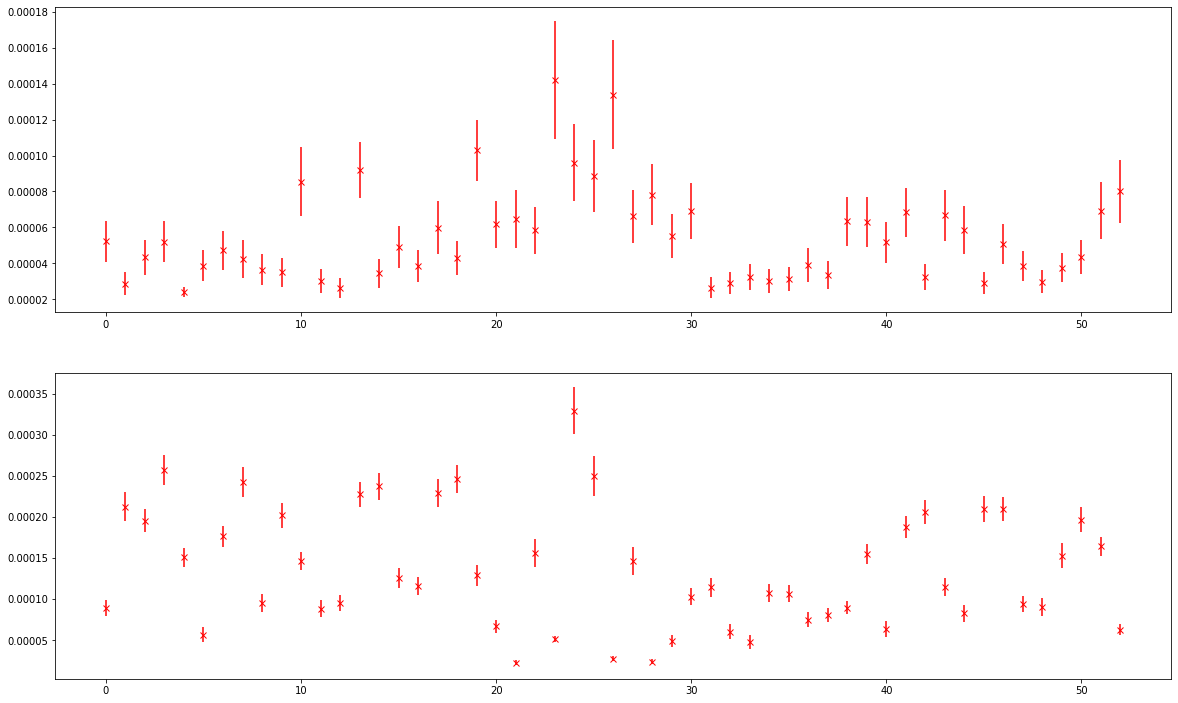

In [12]:
# Compute & plot coupled amplitudes

axy, sigma_axy, _ = Decomposition(X).harmonic_amplitude(nuy, length=128, order=0.25, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=4, method='noise')
ayx, sigma_ayx, _ = Decomposition(Y).harmonic_amplitude(nux, length=128, order=0.25, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=4, method='noise')

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), axy.cpu().numpy(), yerr=sigma_axy.cpu().numpy(), fmt=' ', color='red', marker='x')

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), ayx.cpu().numpy(), yerr=sigma_ayx.cpu().numpy(), fmt=' ', color='red', marker='x')

plt.show()

In [13]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, axx, ayy, fxx, fyy, sigma_nux, sigma_nuy, sigma_axx, sigma_ayy, sigma_fxx, sigma_fyy,
    x=X.work,
    y=Y.work,
    accumulate=True,
    dtype=dtype,
    device=device)

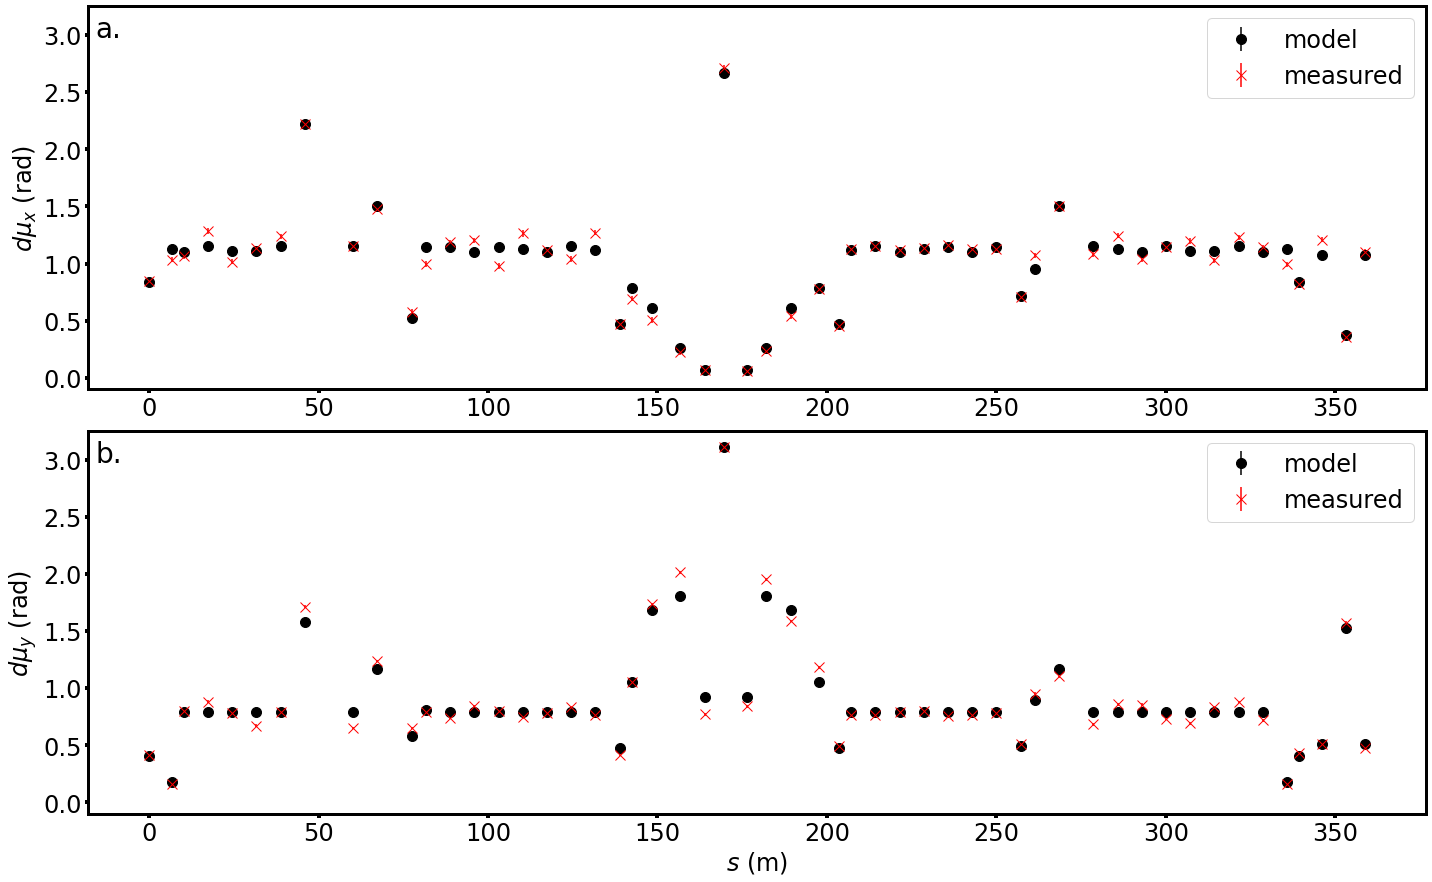

In [14]:
# FIG

# Compare phase advance between adjacent monitor locations

mqx, mqy = model.out_tune_fractional
mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), mux.cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', ms=10, marker='o', color='black', label='model')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_x.cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='measured')
ax.set_ylabel(r'$d\mu_x$ (rad)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.legend(loc=1, prop={'size': 24})
ax.set_ylim(-0.1, 3.25)

plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), muy.cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', ms=10, marker='o', color='black', label='model')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), table.phase_y.cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='measured')
ax.set_ylabel(r'$d\mu_y$ (rad)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.legend(loc=1, prop={'size': 24})
ax.set_ylim(-0.1, 3.25)

ax.set_xlabel(r'$s$ (m)', fontsize=24)

plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("05_advance.png", format="png", dpi=300)

plt.show()

In [15]:
# Set twiss 

twiss = Twiss(model, table, limit=4)

In [16]:
# Estimate twiss from amplitude

twiss.get_action()
twiss.get_twiss_from_amplitude()

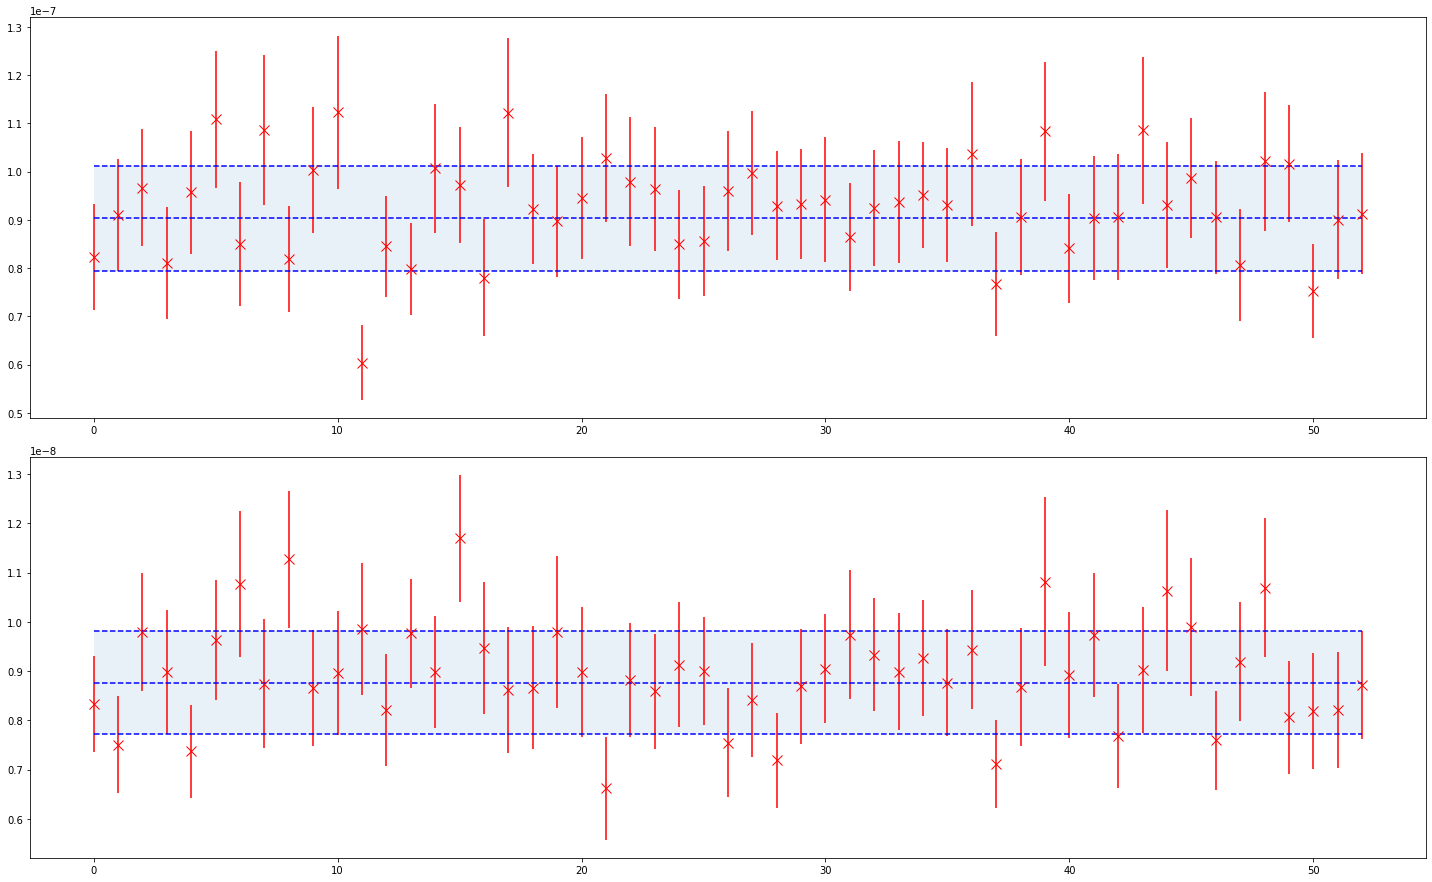

[9.02706161e-08 1.09568506e-08]
[8.76667295e-09 1.04361273e-09]


In [17]:
# Plot actions

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), twiss.action['jx'].cpu().numpy(), yerr=twiss.action['sigma_jx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), twiss.action['center_jx'].cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy(), alpha=0.1)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), twiss.action['jy'].cpu().numpy(), yerr=twiss.action['sigma_jy'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), twiss.action['center_jy'].cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy(), alpha=0.1)

plt.tight_layout()
plt.show()

print(torch.stack([twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())

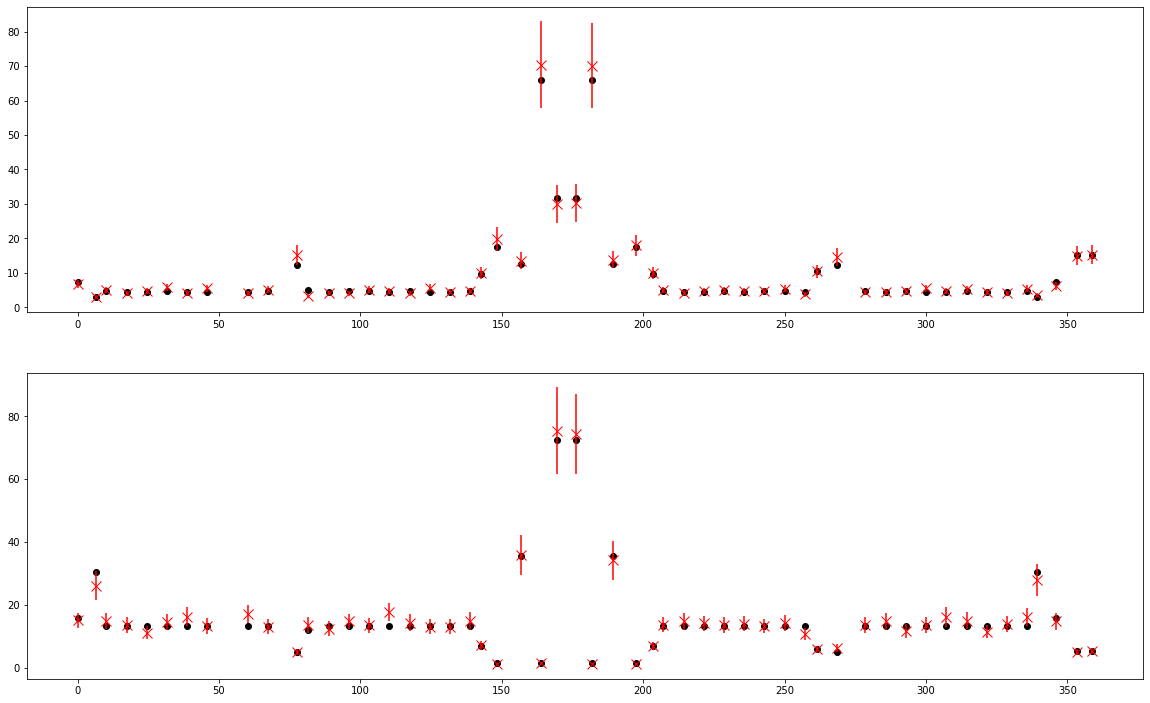

In [18]:
# Plot twiss

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')

plt.show()

In [19]:
# Estimate twiss from phase

twiss.phase_virtual()
twiss.get_twiss_from_phase()

mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True) ;

mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='y', mask=mask_y, weight=True) ;

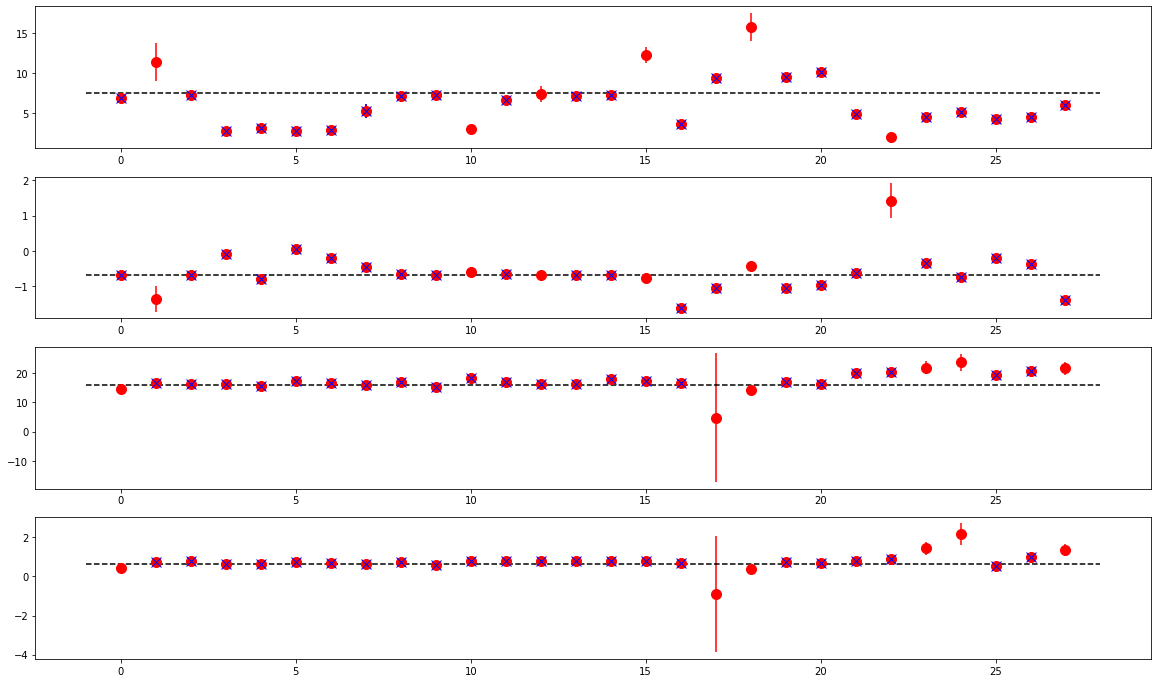

In [20]:
# Plot combinations

probe = 1
index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', ms=10, color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', ms=10, color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', ms=10, color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', ms=10, color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', ms=10, color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', ms=10, color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', ms=10, color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

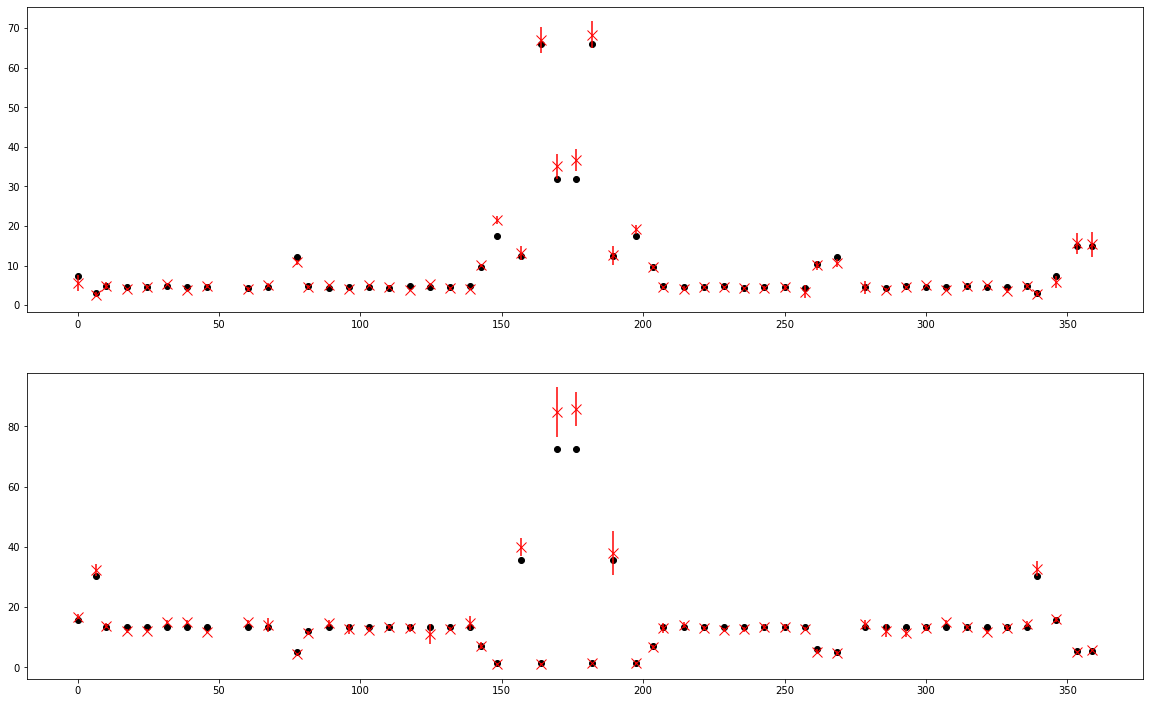

In [21]:
# Plot twiss

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')

plt.show()

In [22]:
twiss.get_action(bx=twiss.bx[model.monitor_index],
                 by=twiss.by[model.monitor_index],
                 sigma_bx=twiss.sigma_bx[model.monitor_index],
                 sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

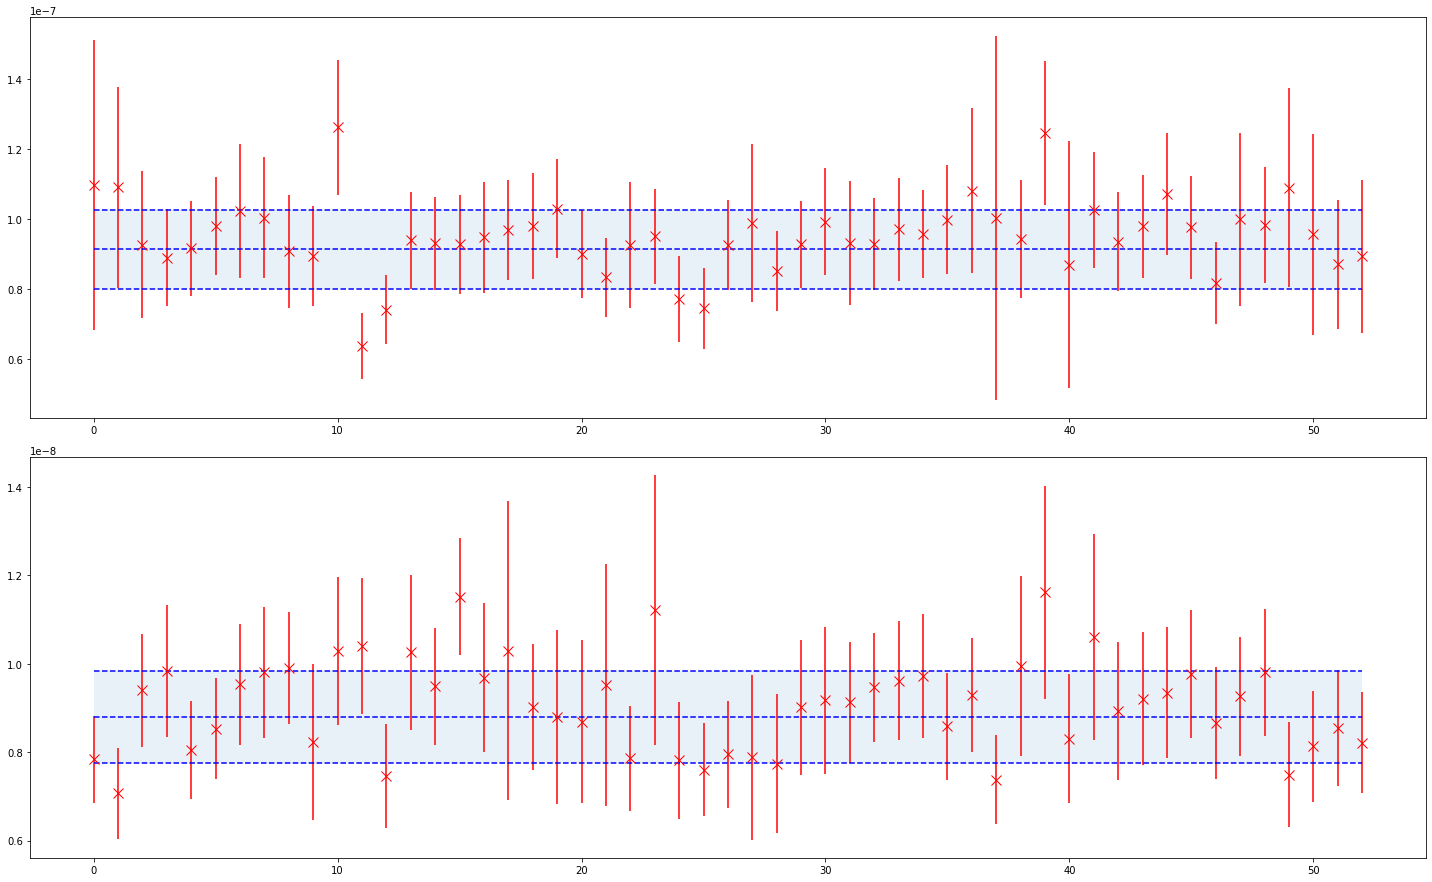

[9.13216956e-08 1.13709805e-08]
[8.78922762e-09 1.03747523e-09]


In [23]:
# Plot actions

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), twiss.action['jx'].cpu().numpy(), yerr=twiss.action['sigma_jx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), twiss.action['center_jx'].cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy(), alpha=0.1)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), twiss.action['jy'].cpu().numpy(), yerr=twiss.action['sigma_jy'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), twiss.action['center_jy'].cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy(), alpha=0.1)

plt.tight_layout()
plt.show()

print(torch.stack([twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())

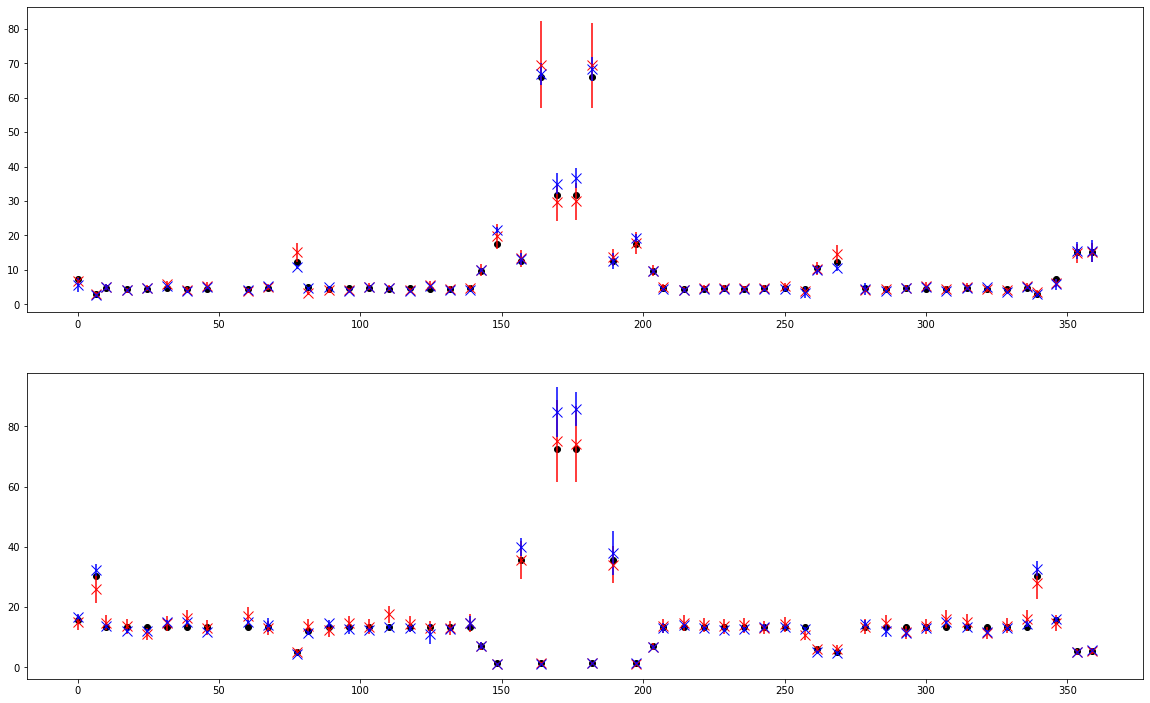

In [24]:
# Plot twiss (from ampliude and phase)

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

plt.show()

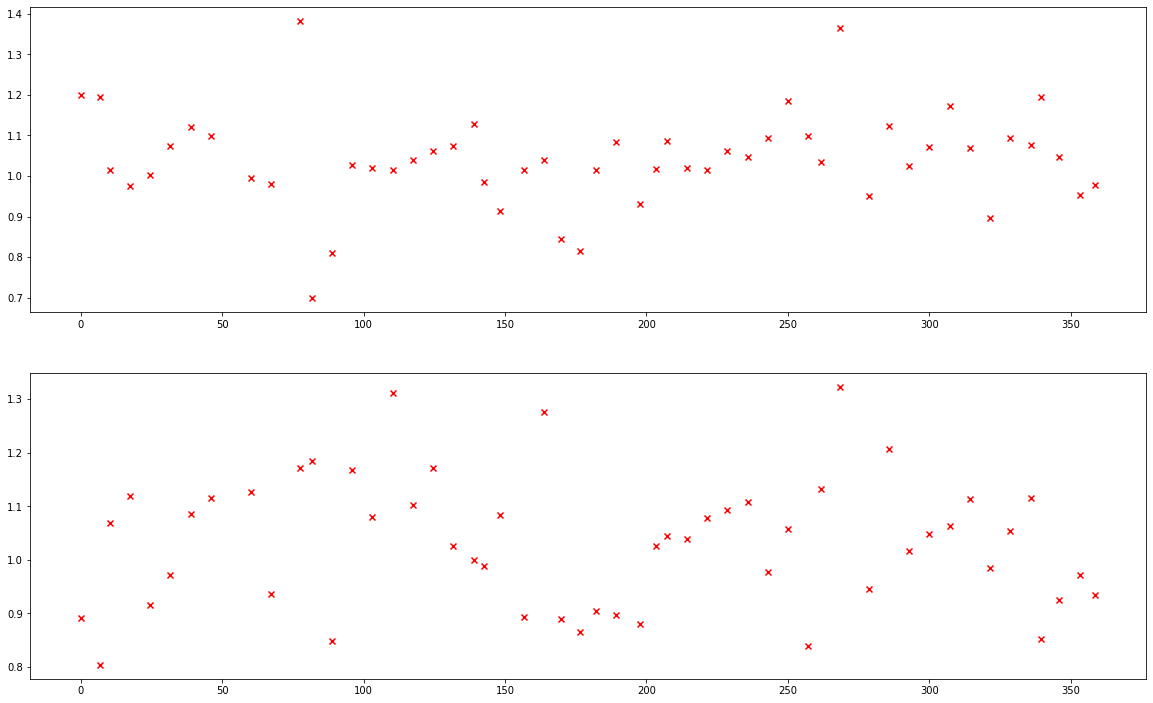

In [25]:
# Ratio

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx']/twiss.bx[model.monitor_index].cpu().numpy(), marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by']/twiss.by[model.monitor_index].cpu().numpy(), marker='x', color='red')

plt.show()

In [26]:
# Estimate twiss from amplitude (use twiss from phase for action estimation)

twiss.get_action(bx=twiss.bx[model.monitor_index],
                 by=twiss.by[model.monitor_index],
                 sigma_bx=twiss.sigma_bx[model.monitor_index],
                 sigma_by=twiss.sigma_by[model.monitor_index])

twiss.get_twiss_from_amplitude()

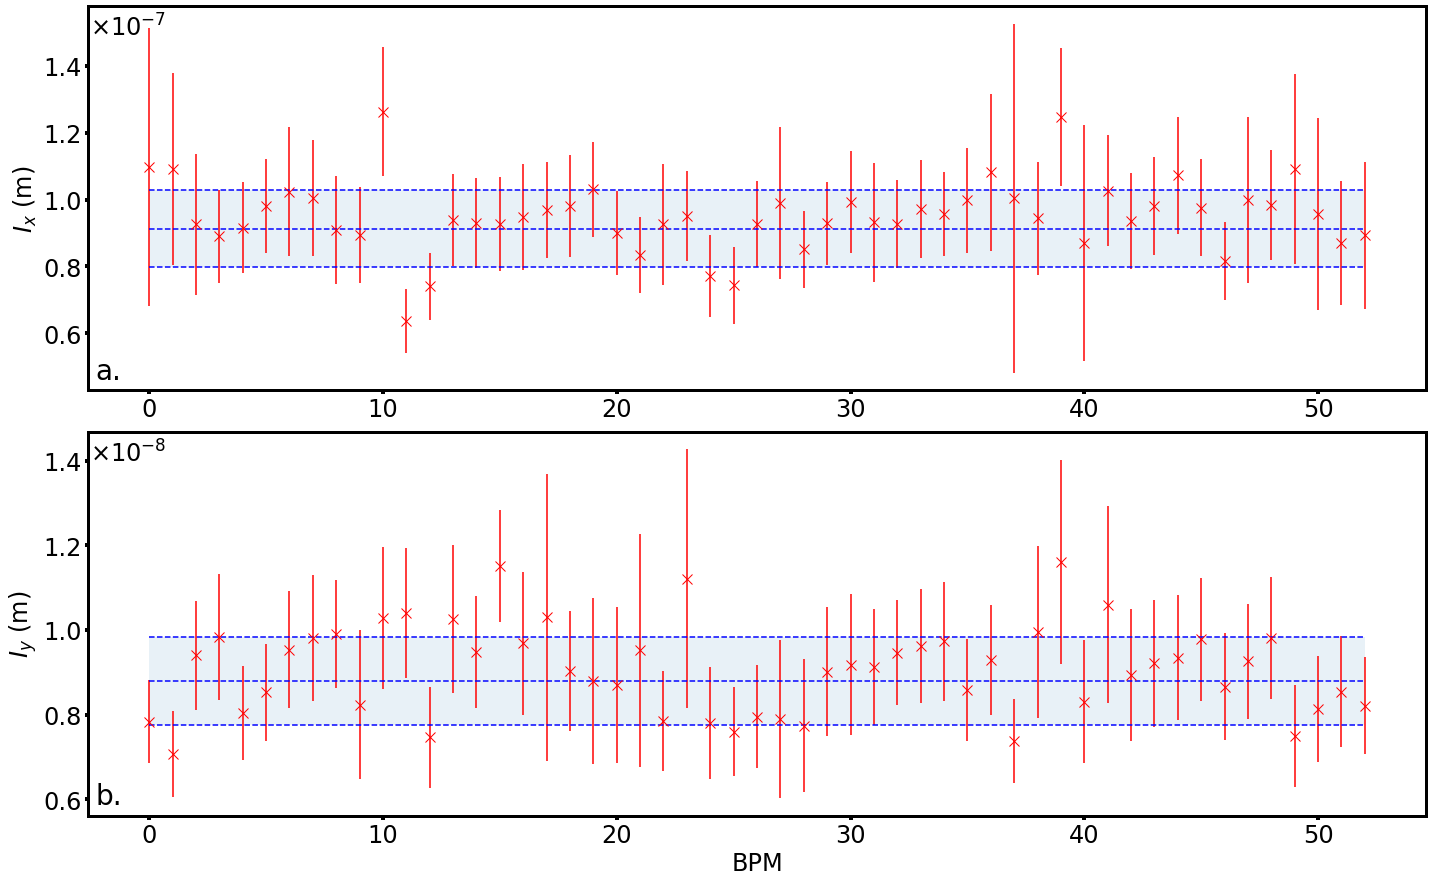

[9.13216956e-08 1.13709805e-08]
[8.78922762e-09 1.03747523e-09]


In [27]:
# FIG

# Plot actions

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), twiss.action['jx'].cpu().numpy(), yerr=twiss.action['sigma_jx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), twiss.action['center_jx'].cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy(), alpha=0.1)
ax.set_ylabel('$I_x$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.offsetText.set_visible(0)

plt.text(0.03, 0.945, r'$\times 10^{-7}$', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)

plt.text(0.015,  0.05, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), twiss.action['jy'].cpu().numpy(), yerr=twiss.action['sigma_jy'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red')
ax.hlines([(twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), twiss.action['center_jy'].cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy(), alpha=0.1)
ax.set_ylabel('$I_y$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.offsetText.set_visible(0)

ax.set_xlabel('BPM', fontsize=24)

plt.text(0.03, 0.945, r'$\times 10^{-8}$', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)

plt.text(0.015,  0.05, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("06_action.png", format="png", dpi=300)

plt.show()

print(torch.stack([twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())

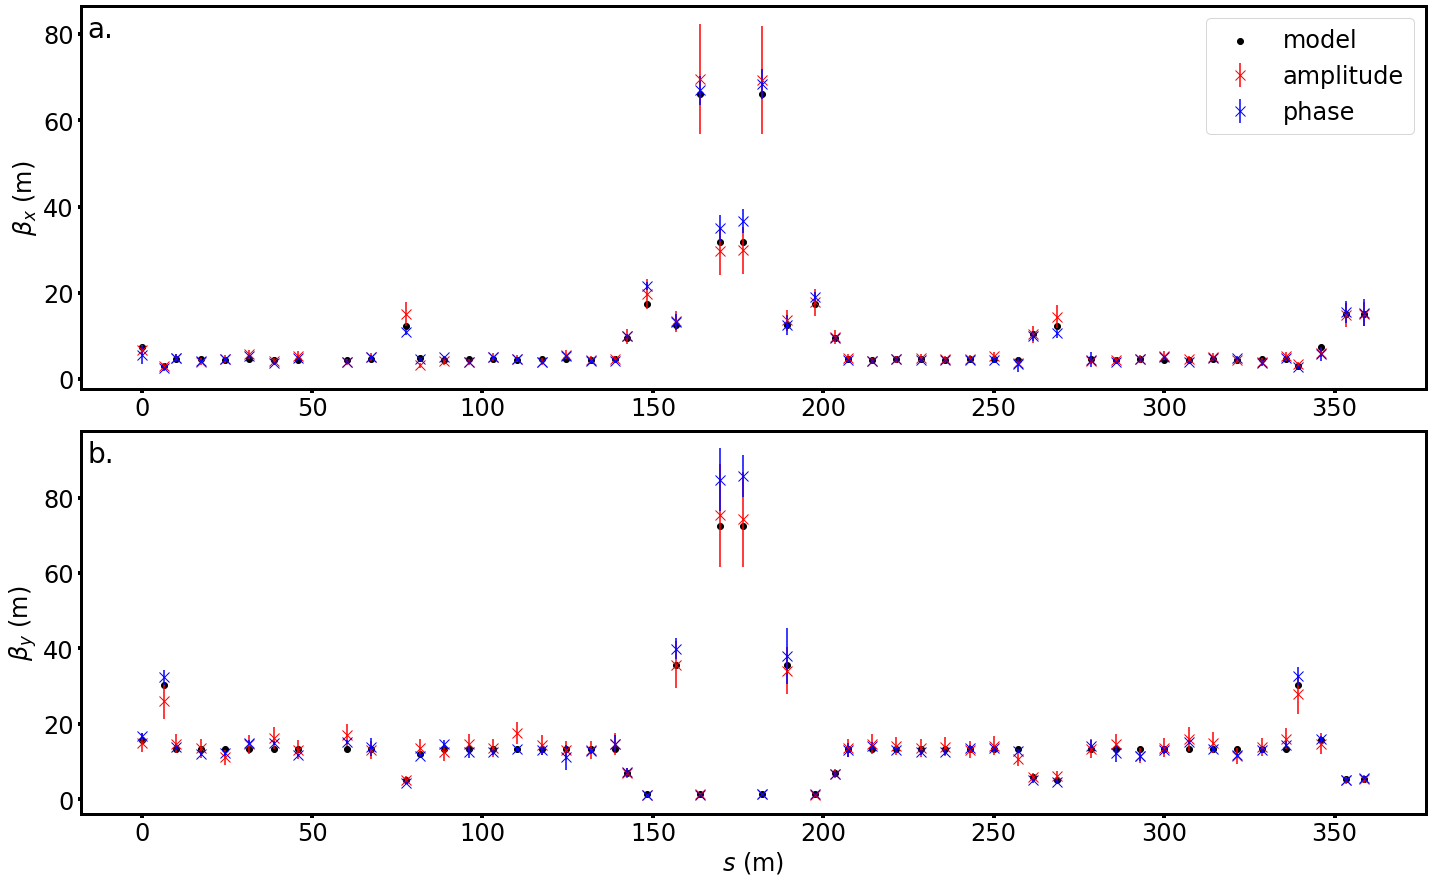

In [28]:
# FIG

# Plot twiss (from amplitude and phase)

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black', label='model')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='amplitude')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue', label='phase')
ax.set_ylabel(r'$\beta_x$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.legend(loc=1, prop={'size': 24})
# ax.set_ylim(-5, 100)

plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black', label='model')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='amplitude')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue', label='phase')
ax.set_ylabel(r'$\beta_y$ (m)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
# ax.legend(loc=1, prop={'size': 24})
# ax.set_ylim(-5, 100)

ax.set_xlabel('$s$ (m)', fontsize=24)

plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("07_uncoupled_twiss.png", format="png", dpi=300)

plt.show()

In [29]:
# Compute orbits

limit = 2
orbit1 = []
for location in range(model.monitor_count):
    orbit1.append(twiss.get_momenta_lstsq(1, 128, location, limit, model.matrix))
orbit1 = torch.stack(orbit1)
print(orbit1.shape)

limit = 2
orbit2 = []
for location in range(model.monitor_count):
    orbit2.append(twiss.get_momenta_lstsq(1, 128, location, limit, twiss.matrix))
orbit2 = torch.stack(orbit2)
print(orbit2.shape)

torch.Size([53, 4, 128])
torch.Size([53, 4, 128])


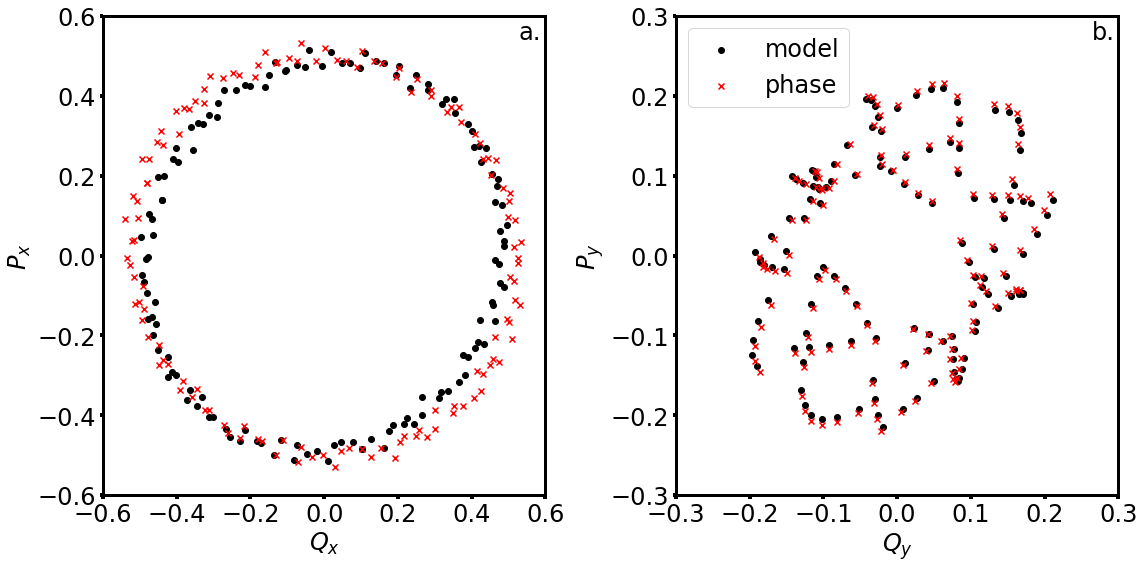

In [30]:
# FIG

# Plot trajectory

index = 1
select = model.monitor_index[index]

qx1, px1, qy1, py1 = orbit1[index]
Qx1, Px1, Qy1, Py1 = (model.out_normal[select].inverse() @ orbit1[index]).cpu().numpy()

from src.parameterization import cs_normal
normal = cs_normal(twiss.ax[select], twiss.bx[select], twiss.ay[select], twiss.by[select])
qx2, px2, qy2, py2 = orbit2[index]
Qx2, Px2, Qy2, Py2 = (normal.inverse() @ orbit2[index]).cpu().numpy()

plt.figure(figsize=(2*8, 8))
ax = plt.subplot(121)
ax.scatter(1000*Qx1, 1000*Px1, color='black', marker='o', label='model')
ax.scatter(1000*Qx2, 1000*Px2, color='red', marker='x', label='phase')
ax.set_xlabel(r'$Q_x$', fontsize=24)
ax.set_ylabel(r'$P_x$', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)

plt.text(0.965, 0.965, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(122)
ax.scatter(1000*Qy1, 1000*Py1, color='black', marker='o', label='model')
ax.scatter(1000*Qy2, 1000*Py2, color='red', marker='x', label='phase')
ax.set_xlabel(r'$Q_y$', fontsize=24)
ax.set_ylabel(r'$P_y$', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.legend(loc=2, prop={'size': 24})

plt.text(0.965, 0.965, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("09_uncoupled_normalization.png", format="png", dpi=300)

plt.show()

In [31]:
# Estimate twiss from invariant fit

from src.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1, 128, parametric_normal, model.matrix, count=128, verbose=False, n_jobs=N_JOBS, method='lstsq', limit=2)
print(data.shape)

torch.Size([53, 2, 10, 128])


In [32]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

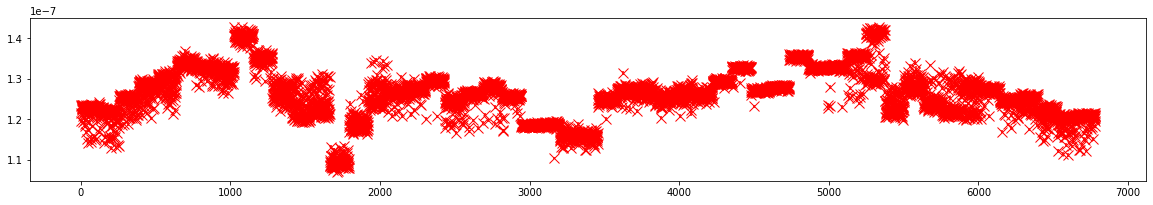

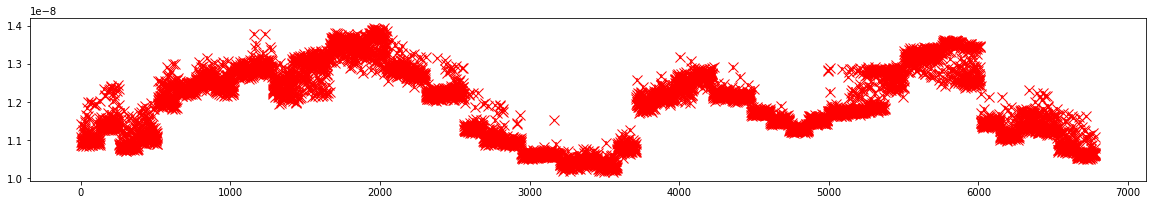

In [33]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(len(ix)*128), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', ms=10, color='red', marker='x', zorder=0)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(len(iy)*128), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', ms=10, color='red', marker='x', zorder=0)
plt.show()

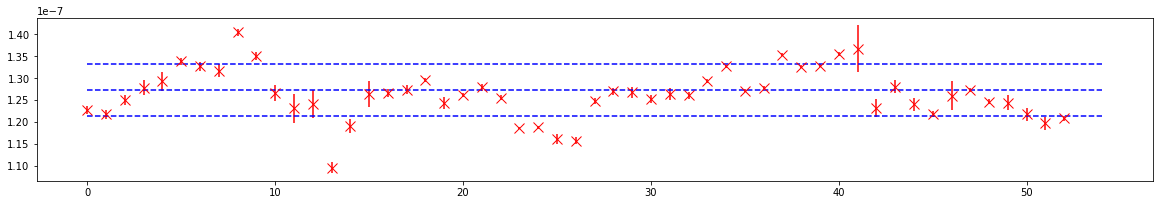

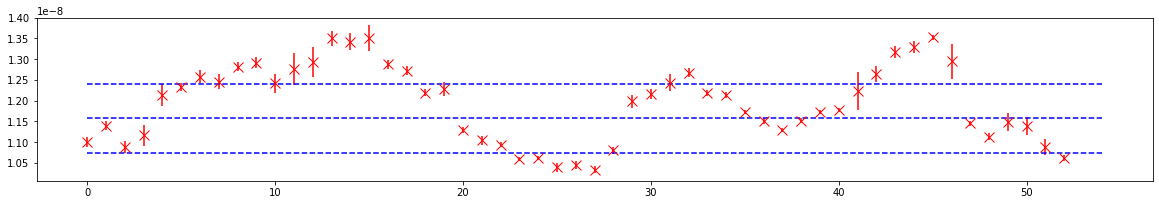

In [34]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

In [35]:
# Process twiss & compare

value_n11 = data[:, 0, 2]
error_n11 = data[:, 1, 2]

value_n33 = data[:, 0, 3]
error_n33 = data[:, 1, 3]

value_n21 = data[:, 0, 4]
error_n21 = data[:, 1, 4]

value_n43 = data[:, 0, 5]
error_n43 = data[:, 1, 5]

value_n13 = data[:, 0, 6]
error_n13 = data[:, 1, 6]

value_n31 = data[:, 0, 7]
error_n31 = data[:, 1, 7]

value_n14 = data[:, 0, 8]
error_n14 = data[:, 1, 8]

value_n41 = data[:, 0, 9]
error_n41 = data[:, 1, 9]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

from src.parameterization import parametric_normal
from src.parameterization import normal_to_wolski
from src.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

wolski_value, wolski_error = [], []
cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    wolski_value.append(table.mean(0))
    wolski_error.append(table.std(0))
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

wolski_value = torch.stack(wolski_value)
wolski_error = torch.stack(wolski_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

v1_n11, e1_n11 = value_n11.clone(), error_n11.clone()
v1_n33, e1_n33 = value_n33.clone(), error_n33.clone()
v1_n21, e1_n21 = value_n21.clone(), error_n21.clone()
v1_n43, e1_n43 = value_n43.clone(), error_n43.clone()
v1_n13, e1_n13 = value_n13.clone(), error_n13.clone()
v1_n31, e1_n31 = value_n31.clone(), error_n31.clone()
v1_n14, e1_n14 = value_n14.clone(), error_n14.clone()
v1_n41, e1_n41 = value_n41.clone(), error_n41.clone()

v1_ax, v1_bx, v1_ay, v1_by = cs_value.T.clone()
e1_ax, e1_bx, e1_ay, e1_by = cs_error.T.clone()

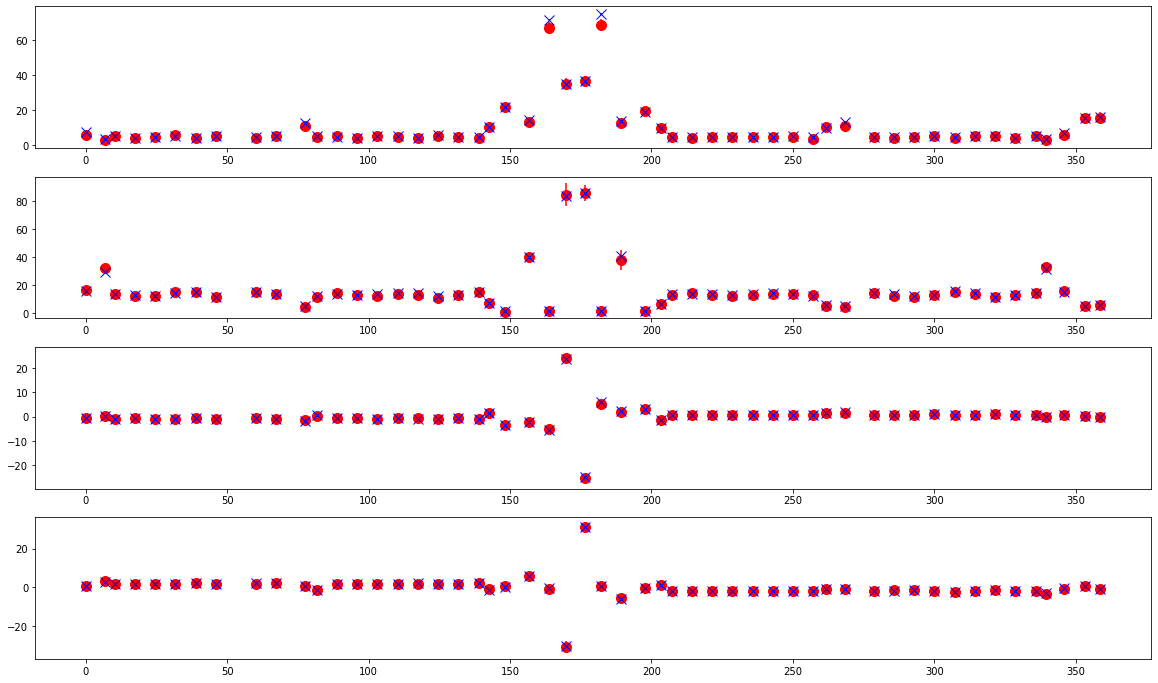

In [36]:
plt.figure(figsize=(20, 3*4))

ax = plt.subplot(411)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(412)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(413)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.ax[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_ax[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_ax.cpu().numpy(), yerr=error_ax.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(414)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.ay[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_ay[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_ay.cpu().numpy(), yerr=error_ay.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

plt.show()

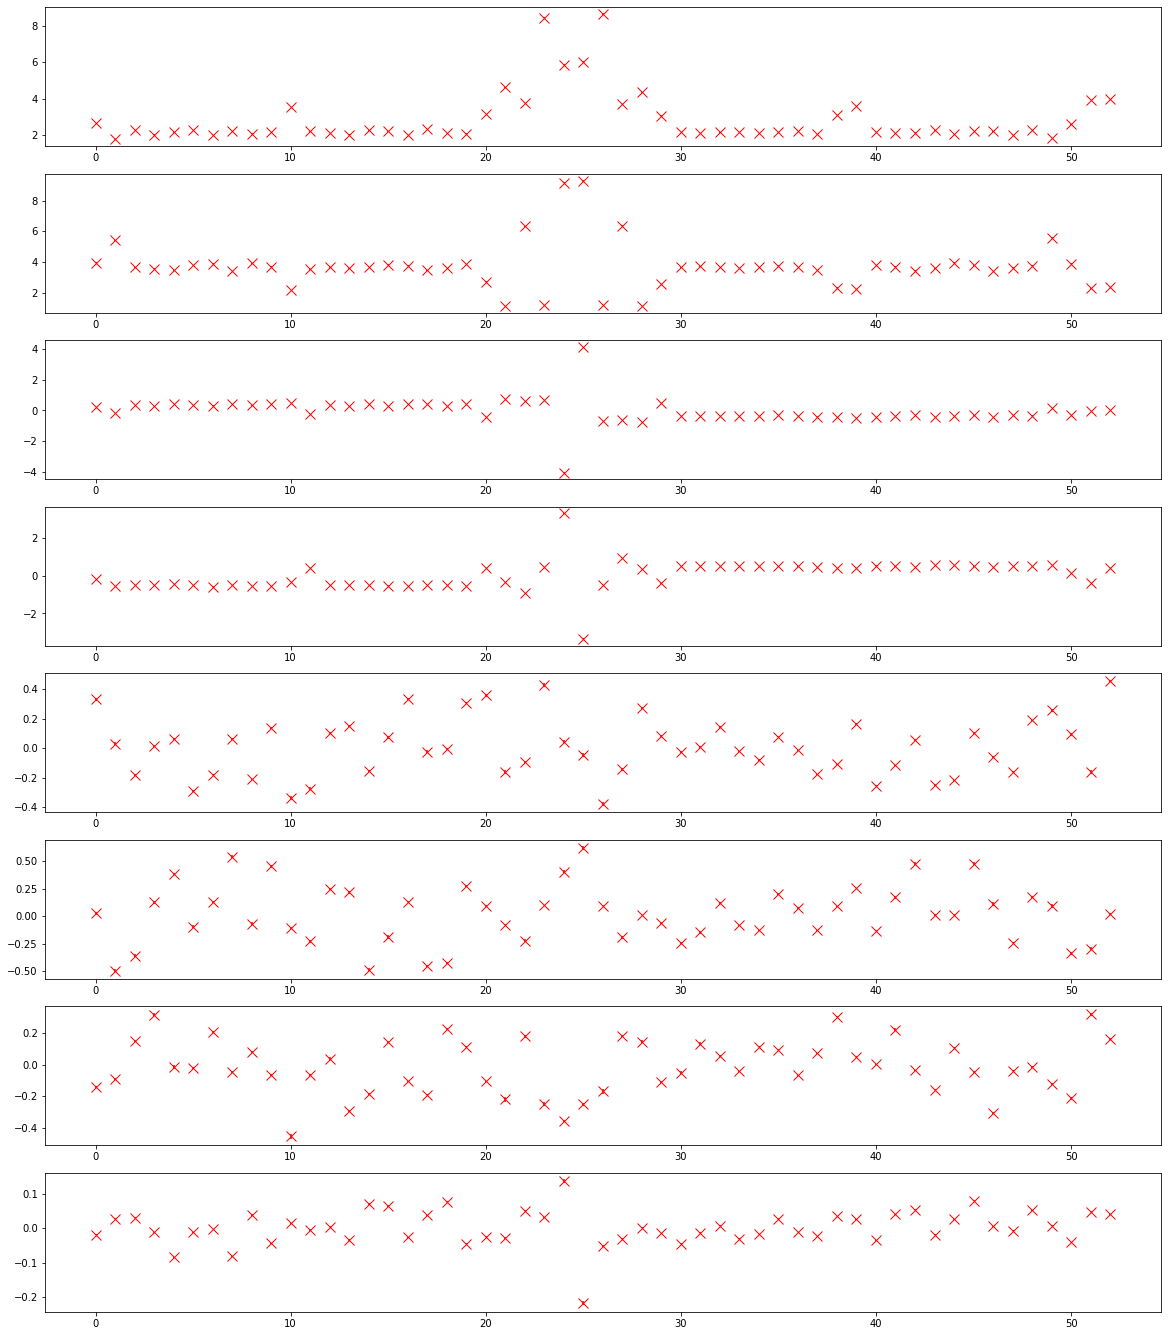

In [37]:
# Plot normalization matrix

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(812)
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(813)
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(814)
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(815)
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(816)
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(817)
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(818)
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', ms=10, color='red', marker='x')

plt.show()

In [38]:
# Compute orbits

limit = 2
orbit1 = []
for location in range(model.monitor_count):
    orbit1.append(twiss.get_momenta_lstsq(1, 128, location, limit, model.matrix))
orbit1 = torch.stack(orbit1)
print(orbit1.shape)

limit = 2
orbit2 = []
for location in range(model.monitor_count):
    orbit2.append(twiss.get_momenta_lstsq(1, 128, location, limit, twiss.matrix))
orbit2 = torch.stack(orbit2)
print(orbit2.shape)

torch.Size([53, 4, 128])
torch.Size([53, 4, 128])


tensor([[1.612959500332e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-1.505531809260e-01, 6.199783688269e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 5.685278444636e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -5.806543273284e-01, 1.758928801356e-01]],
       dtype=torch.float64)
tensor([[1.761111121966e+00, 0.000000000000e+00, 3.036111616971e-02, -8.852946173261e-02],
        [-1.724860315776e-01, 5.703516530791e-01, -7.114429265466e-02, 6.079243775904e-02],
        [-4.964748463625e-01, -2.731003586752e-01, 5.432768590962e+00, 0.000000000000e+00],
        [2.790003140333e-02, 2.431572987186e-02, -5.471184550459e-01, 1.848878012842e-01]],
       dtype=torch.float64)


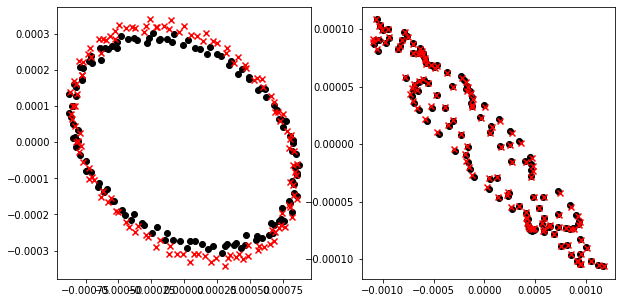

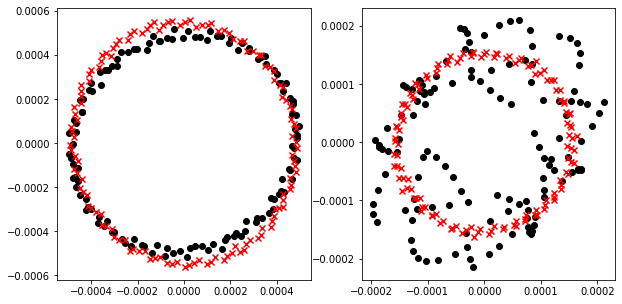

In [39]:
# Plot trajectory

index = 1
select = model.monitor_index[index]

qx1, px1, qy1, py1 = orbit1[index]
Qx1, Px1, Qy1, Py1 = (model.out_normal[select].inverse() @ orbit1[index]).cpu().numpy()

from src.parameterization import cs_normal, parametric_normal

normal = cs_normal(twiss.ax[select], twiss.bx[select], twiss.ay[select], twiss.by[select])
print(normal)

normal = parametric_normal(value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index])
print(normal)

qx2, px2, qy2, py2 = orbit2[index]
Qx2, Px2, Qy2, Py2 = (normal.inverse() @ orbit2[index]).cpu().numpy()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(qx1, px1, color='black', marker='o')
ax.scatter(qx2, px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(qy1, py1, color='black', marker='o')
ax.scatter(qy2, py2, color='red', marker='x')
plt.show()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(Qx1, Px1, color='black', marker='o')
ax.scatter(Qx2, Px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(Qy1, Py1, color='black', marker='o')
ax.scatter(Qy2, Py2, color='red', marker='x')
plt.show()

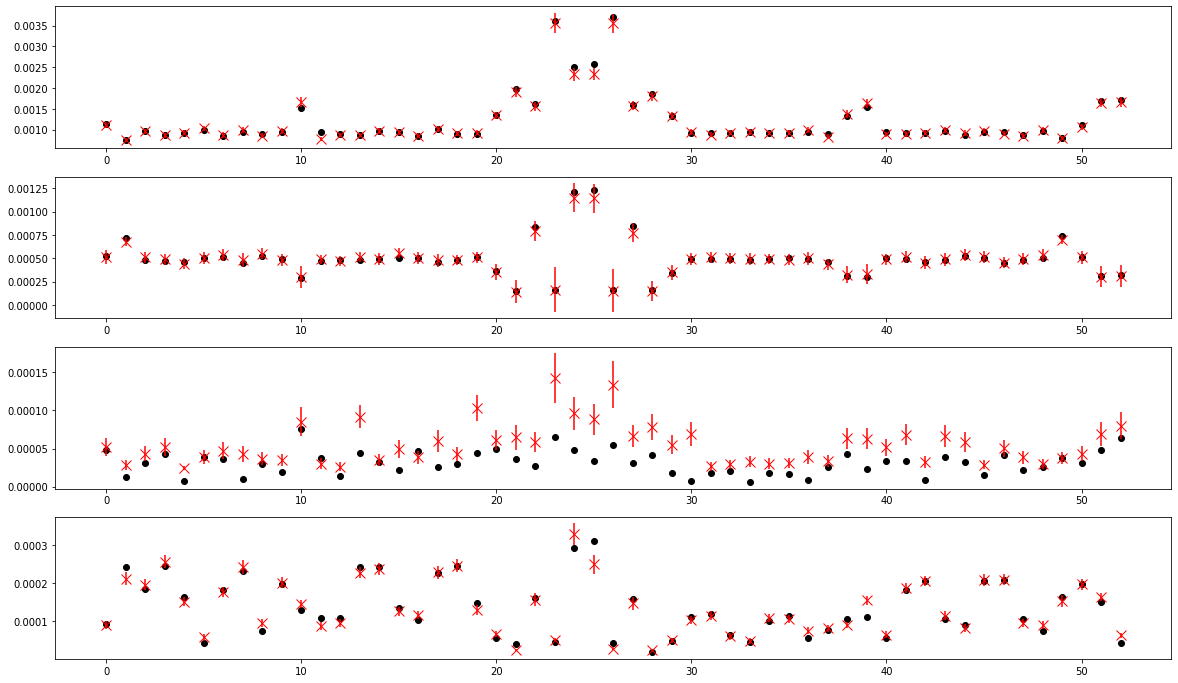

In [40]:
# Coupled beta functions

plt.figure(figsize=(20, 3*4))

ax = plt.subplot(411)
ax.errorbar(range(model.monitor_count), axx.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

ax = plt.subplot(412)
ax.errorbar(range(model.monitor_count), ayy.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n33**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')

ax = plt.subplot(413)
ax.errorbar(range(model.monitor_count), axy.cpu().numpy(), yerr=sigma_axy.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n13**2 + value_n14**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')

ax = plt.subplot(414)
ax.errorbar(range(model.monitor_count), ayx.cpu().numpy(), yerr=sigma_ayx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n31**2 + value_n14**2*value_n33**2/value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

plt.show()

In [41]:
# Estimate twiss from ratio

from src.parameterization import parametric_normal
window = Window.cosine_window(128, 0.5, dtype=dtype, device=device)
data = twiss.get_twiss_from_ratio(1, 256, window, nux, nuy, parametric_normal, model.matrix, method='lstsq', limit=2, step=4, n_jobs=N_JOBS, verbose=False)
print(data.shape)

torch.Size([53, 2, 8, 33])


In [42]:
# Process twiss & compare

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

from src.parameterization import parametric_normal
from src.parameterization import normal_to_wolski
from src.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

wolski_value, wolski_error = [], []
cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    wolski_value.append(table.mean(0))
    wolski_error.append(table.std(0))
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

wolski_value = torch.stack(wolski_value)
wolski_error = torch.stack(wolski_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

v2_n11, e2_n11 = value_n11.clone(), error_n11.clone()
v2_n33, e2_n33 = value_n33.clone(), error_n33.clone()
v2_n21, e2_n21 = value_n21.clone(), error_n21.clone()
v2_n43, e2_n43 = value_n43.clone(), error_n43.clone()
v2_n13, e2_n13 = value_n13.clone(), error_n13.clone()
v2_n31, e2_n31 = value_n31.clone(), error_n31.clone()
v2_n14, e2_n14 = value_n14.clone(), error_n14.clone()
v2_n41, e2_n41 = value_n41.clone(), error_n41.clone()

v2_ax, v2_bx, v2_ay, v2_by = cs_value.T.clone()
e2_ax, e2_bx, e2_ay, e2_by = cs_error.T.clone()

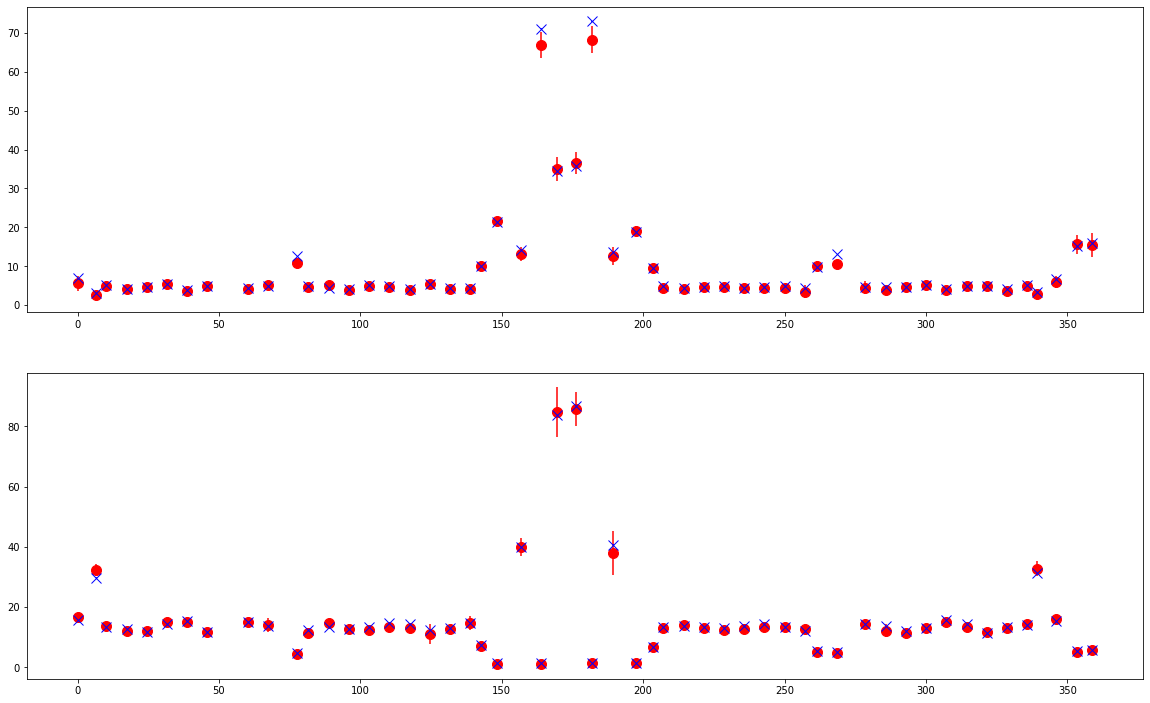

In [43]:
plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

plt.show()

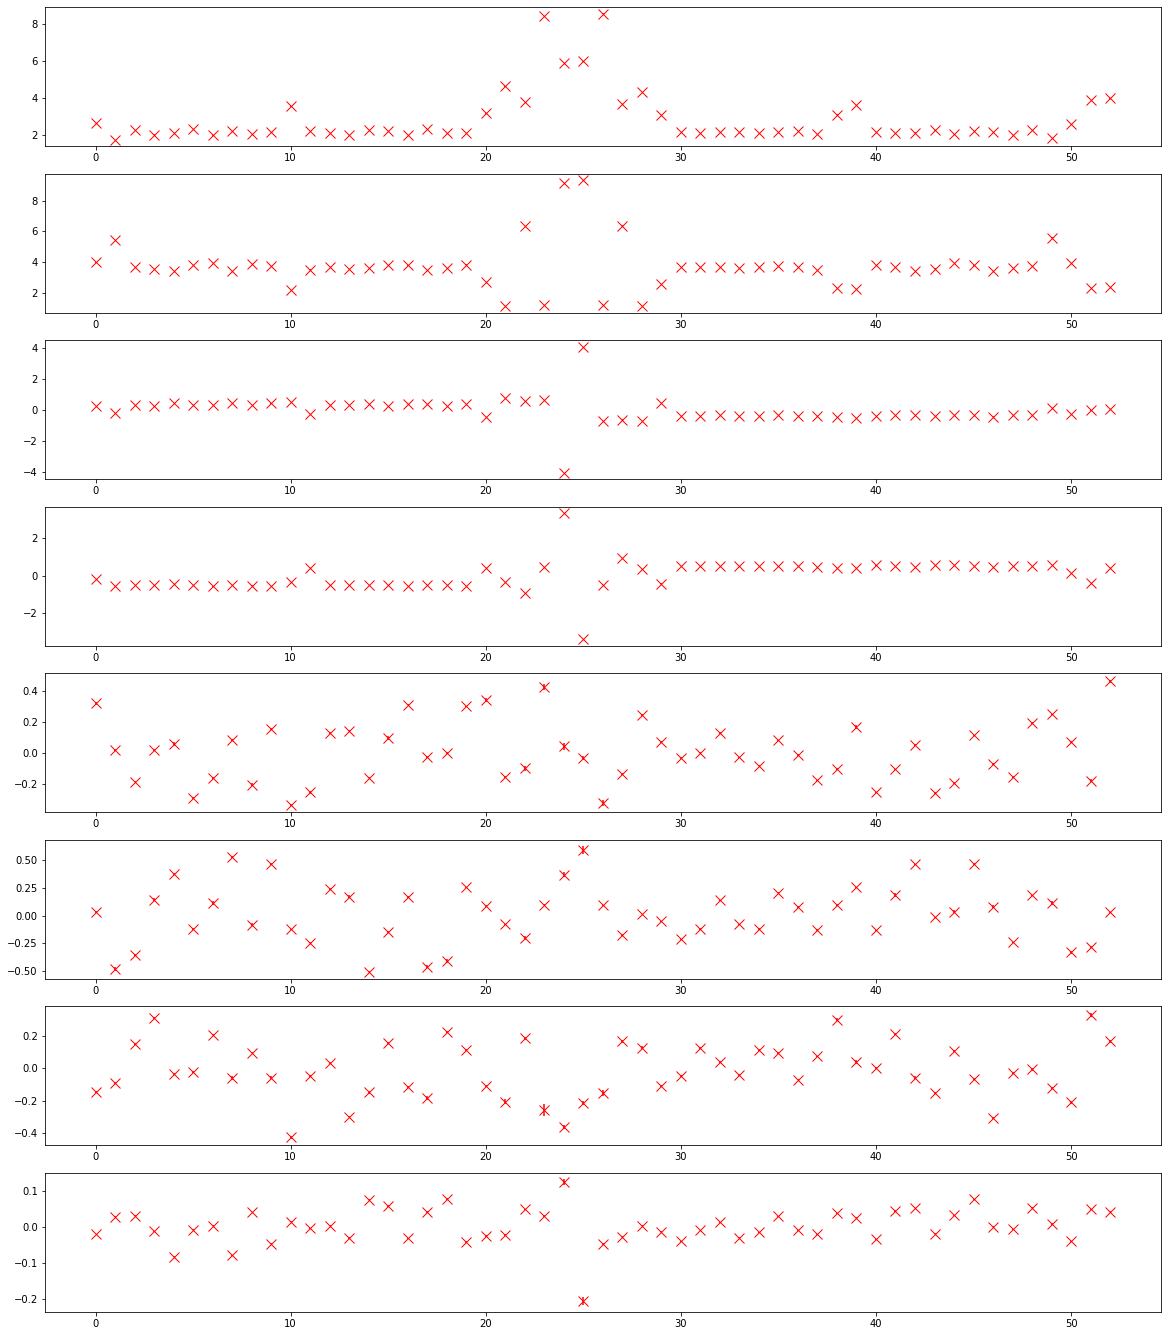

In [44]:
# Plot normalization matrix

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(812)
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(813)
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(814)
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(815)
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(816)
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(817)
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(818)
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', ms=10, color='red', marker='x')

plt.show()

In [45]:
# Compute orbits

limit = 2
orbit1 = []
for location in range(model.monitor_count):
    orbit1.append(twiss.get_momenta_lstsq(1, 128, location, limit, model.matrix))
orbit1 = torch.stack(orbit1)
print(orbit1.shape)

limit = 2
orbit2 = []
for location in range(model.monitor_count):
    orbit2.append(twiss.get_momenta_lstsq(1, 128, location, limit, twiss.matrix))
orbit2 = torch.stack(orbit2)
print(orbit2.shape)

torch.Size([53, 4, 128])
torch.Size([53, 4, 128])


tensor([[1.612959500332e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-1.505531809260e-01, 6.199783688269e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 5.685278444636e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -5.806543273284e-01, 1.758928801356e-01]],
       dtype=torch.float64)
tensor([[1.763871901285e+00, 0.000000000000e+00, 1.917585027824e-02, -8.853004812585e-02],
        [-1.749404792471e-01, 5.695859838036e-01, -6.565303740291e-02, 5.921794065503e-02],
        [-4.834832452219e-01, -2.740377676031e-01, 5.459926074803e+00, 0.000000000000e+00],
        [2.804693476084e-02, 2.556992762262e-02, -5.493119120778e-01, 1.840092152224e-01]],
       dtype=torch.float64)


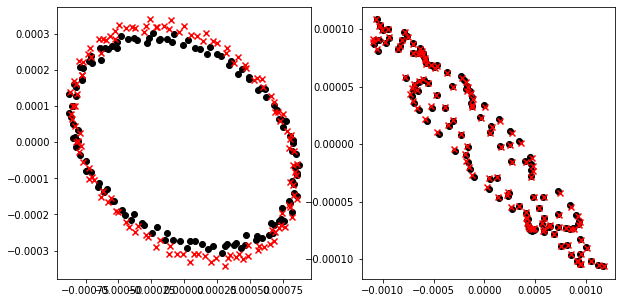

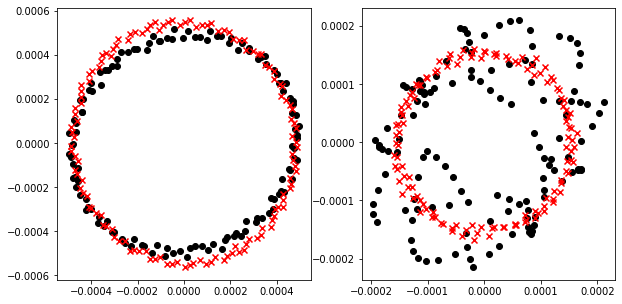

In [46]:
# Plot trajectory

index = 1
select = model.monitor_index[index]

qx1, px1, qy1, py1 = orbit1[index]
Qx1, Px1, Qy1, Py1 = (model.out_normal[select].inverse() @ orbit1[index]).cpu().numpy()

from src.parameterization import cs_normal, parametric_normal

normal = cs_normal(twiss.ax[select], twiss.bx[select], twiss.ay[select], twiss.by[select])
print(normal)

normal = parametric_normal(value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index])
print(normal)

qx2, px2, qy2, py2 = orbit2[index]
Qx2, Px2, Qy2, Py2 = (normal.inverse() @ orbit2[index]).cpu().numpy()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(qx1, px1, color='black', marker='o')
ax.scatter(qx2, px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(qy1, py1, color='black', marker='o')
ax.scatter(qy2, py2, color='red', marker='x')
plt.show()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(Qx1, Px1, color='black', marker='o')
ax.scatter(Qx2, Px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(Qy1, Py1, color='black', marker='o')
ax.scatter(Qy2, Py2, color='red', marker='x')
plt.show()

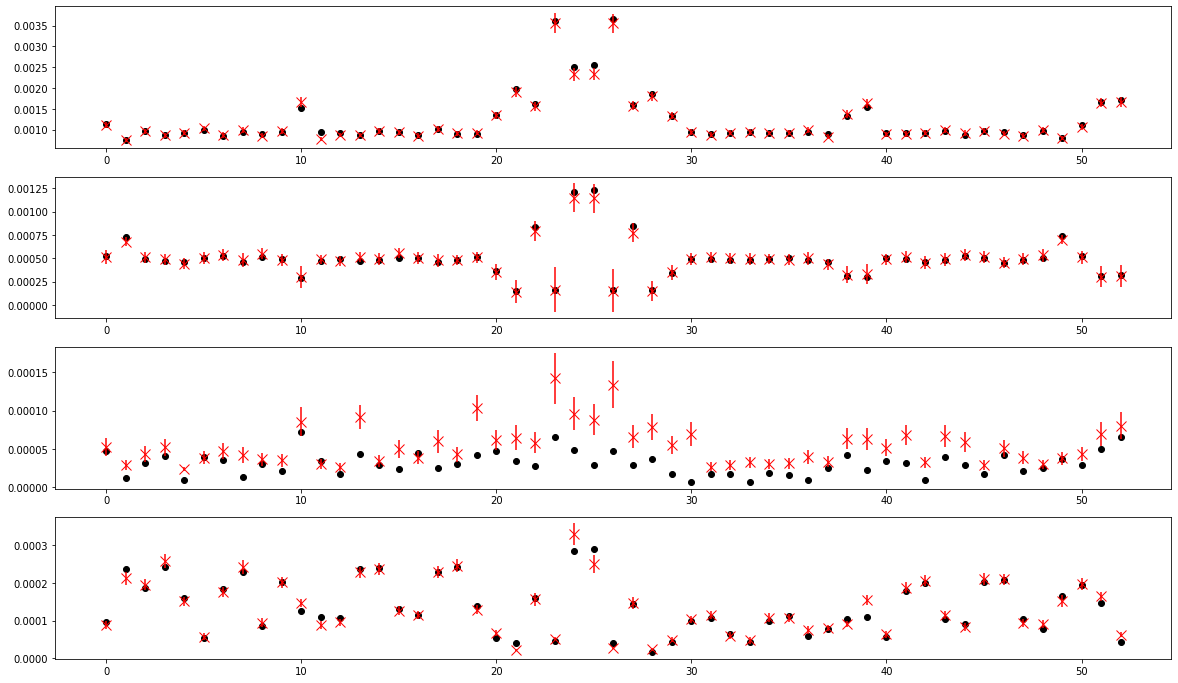

In [47]:
# Coupled beta functions

plt.figure(figsize=(20, 3*4))

ax = plt.subplot(411)
ax.errorbar(range(model.monitor_count), axx.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

ax = plt.subplot(412)
ax.errorbar(range(model.monitor_count), ayy.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n33**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')


ax = plt.subplot(413)
ax.errorbar(range(model.monitor_count), axy.cpu().numpy(), yerr=sigma_axy.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n13**2 + value_n14**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')

ax = plt.subplot(414)
ax.errorbar(range(model.monitor_count), ayx.cpu().numpy(), yerr=sigma_ayx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n31**2 + value_n14**2*value_n33**2/value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

plt.show()

In [48]:
# Estimate twiss from matrix
# Use first 512 turns from each signal to fit 1-turn matrix using 256 samples of length int(0.75*512)

# For each sample in each signal tunes and free normalization matrix elements are returned
# All zeros if matrix is unstable
# (nux, nuy, n11, n33, n21, n43, n13, n31, n14, n41)

data = twiss.get_twiss_from_matrix(1, 128, model.matrix, power=1, count=128, fraction=0.75, method='lstsq', limit=2)
print(data.shape)

torch.Size([53, 10, 128])


In [49]:
# Generate tune mask

from src.statistics import standardize
from src.statistics import median, biweight_midvariance
from src.anomaly import threshold

factor = torch.tensor(6.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

In [50]:
# Process twiss

from src.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

from src.parameterization import parametric_normal
from src.parameterization import normal_to_wolski
from src.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

wolski_value, wolski_error = [], []
cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    wolski_value.append(table.mean(0))
    wolski_error.append(table.std(0))
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

wolski_value = torch.stack(wolski_value)
wolski_error = torch.stack(wolski_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

v3_n11, e3_n11 = value_n11.clone(), error_n11.clone()
v3_n33, e3_n33 = value_n33.clone(), error_n33.clone()
v3_n21, e3_n21 = value_n21.clone(), error_n21.clone()
v3_n43, e3_n43 = value_n43.clone(), error_n43.clone()
v3_n13, e3_n13 = value_n13.clone(), error_n13.clone()
v3_n31, e3_n31 = value_n31.clone(), error_n31.clone()
v3_n14, e3_n14 = value_n14.clone(), error_n14.clone()
v3_n41, e3_n41 = value_n41.clone(), error_n41.clone()

v3_ax, v3_bx, v3_ay, v3_by = cs_value.T.clone()
e3_ax, e3_bx, e3_ay, e3_by = cs_error.T.clone()

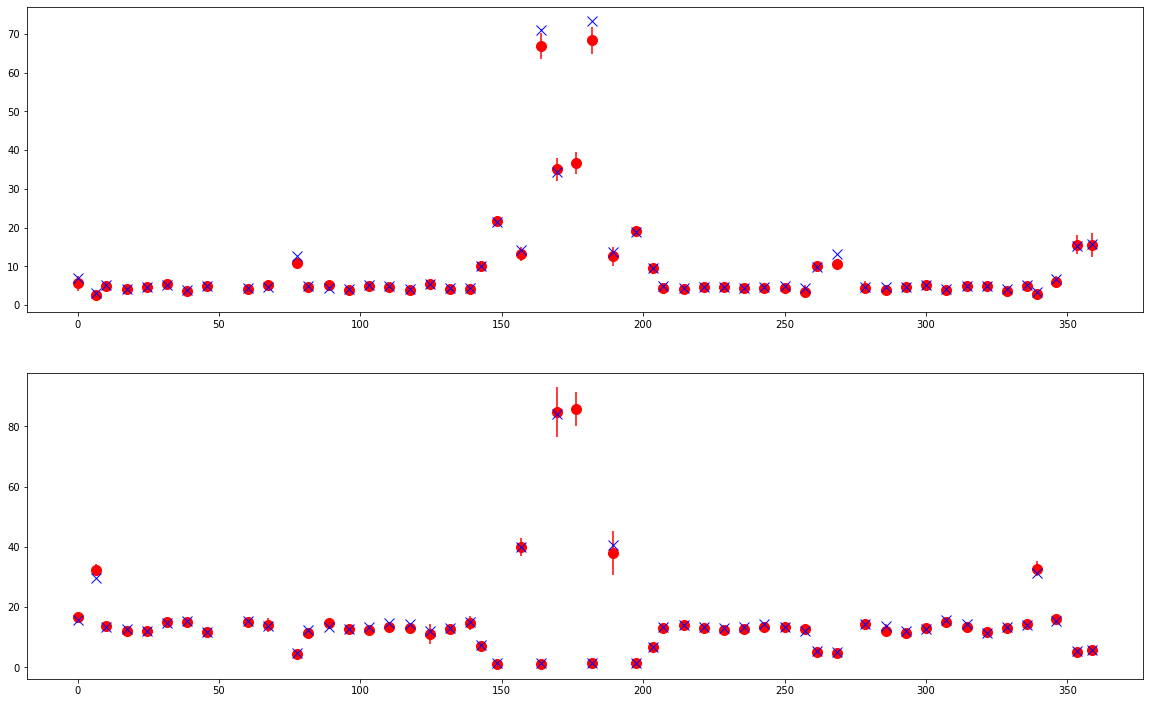

In [51]:
plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue')

plt.show()

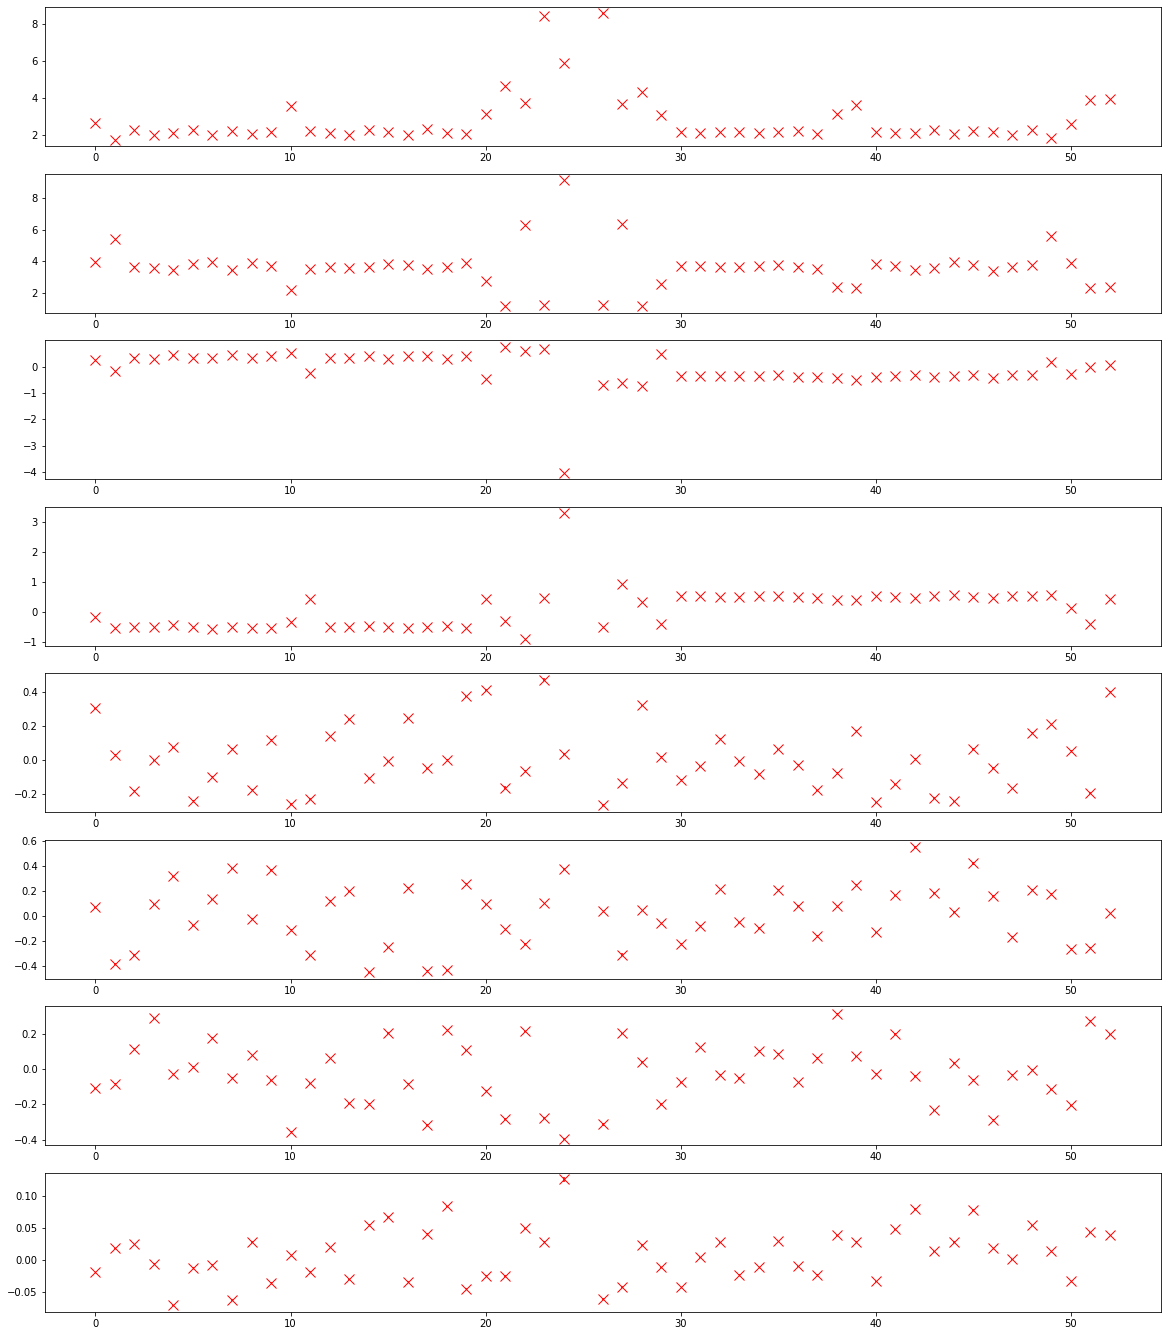

In [52]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(812)
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(813)
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(814)
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(815)
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(816)
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(817)
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', ms=10, color='red', marker='x')

ax = plt.subplot(818)
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', ms=10, color='red', marker='x')

plt.show()

In [53]:
# Compute orbits

limit = 2
orbit1 = []
for location in range(model.monitor_count):
    orbit1.append(twiss.get_momenta_lstsq(1, 128, location, limit, model.matrix))
orbit1 = torch.stack(orbit1)
print(orbit1.shape)

limit = 2
orbit2 = []
for location in range(model.monitor_count):
    orbit2.append(twiss.get_momenta_lstsq(1, 128, location, limit, twiss.matrix))
orbit2 = torch.stack(orbit2)
print(orbit2.shape)

torch.Size([53, 4, 128])
torch.Size([53, 4, 128])


tensor([[1.612959500332e+00, 0.000000000000e+00, 0.000000000000e+00, 0.000000000000e+00],
        [-1.505531809260e-01, 6.199783688269e-01, 0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, 5.685278444636e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00, -5.806543273284e-01, 1.758928801356e-01]],
       dtype=torch.float64)
tensor([[1.762797861087e+00, 0.000000000000e+00, 2.975357642112e-02, -8.308047154693e-02],
        [-1.752109012371e-01, 5.696518517309e-01, -6.784406416215e-02, 4.891684368020e-02],
        [-3.881753259784e-01, -2.563157759588e-01, 5.438497076511e+00, 0.000000000000e+00],
        [1.807702509208e-02, 2.270750333453e-02, -5.479329935047e-01, 1.846431195362e-01]],
       dtype=torch.float64)


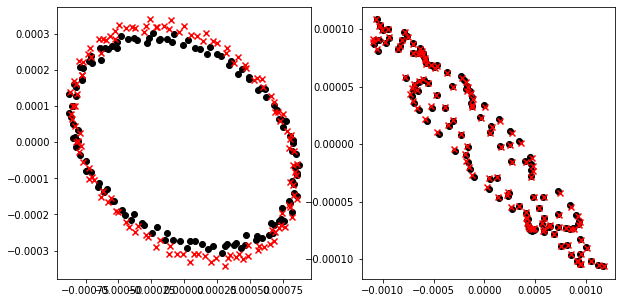

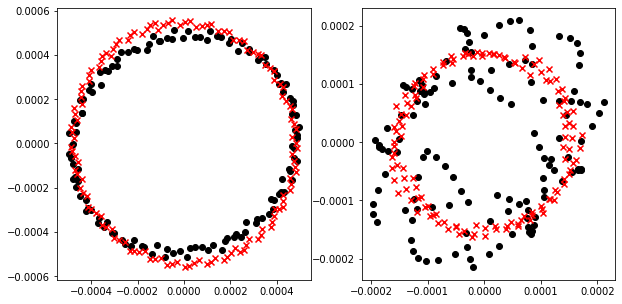

In [54]:
# Plot trajectory

index = 1
select = model.monitor_index[index]

qx1, px1, qy1, py1 = orbit1[index]
Qx1, Px1, Qy1, Py1 = (model.out_normal[select].inverse() @ orbit1[index]).cpu().numpy()

from src.parameterization import cs_normal, parametric_normal

normal = cs_normal(twiss.ax[select], twiss.bx[select], twiss.ay[select], twiss.by[select])
print(normal)

normal = parametric_normal(value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index])
print(normal)

qx2, px2, qy2, py2 = orbit2[index]
Qx2, Px2, Qy2, Py2 = (normal.inverse() @ orbit2[index]).cpu().numpy()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(qx1, px1, color='black', marker='o')
ax.scatter(qx2, px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(qy1, py1, color='black', marker='o')
ax.scatter(qy2, py2, color='red', marker='x')
plt.show()

plt.figure(figsize=(2*5, 5))
ax = plt.subplot(121)
ax.scatter(Qx1, Px1, color='black', marker='o')
ax.scatter(Qx2, Px2, color='red', marker='x')
ax = plt.subplot(122)
ax.scatter(Qy1, Py1, color='black', marker='o')
ax.scatter(Qy2, Py2, color='red', marker='x')
plt.show()

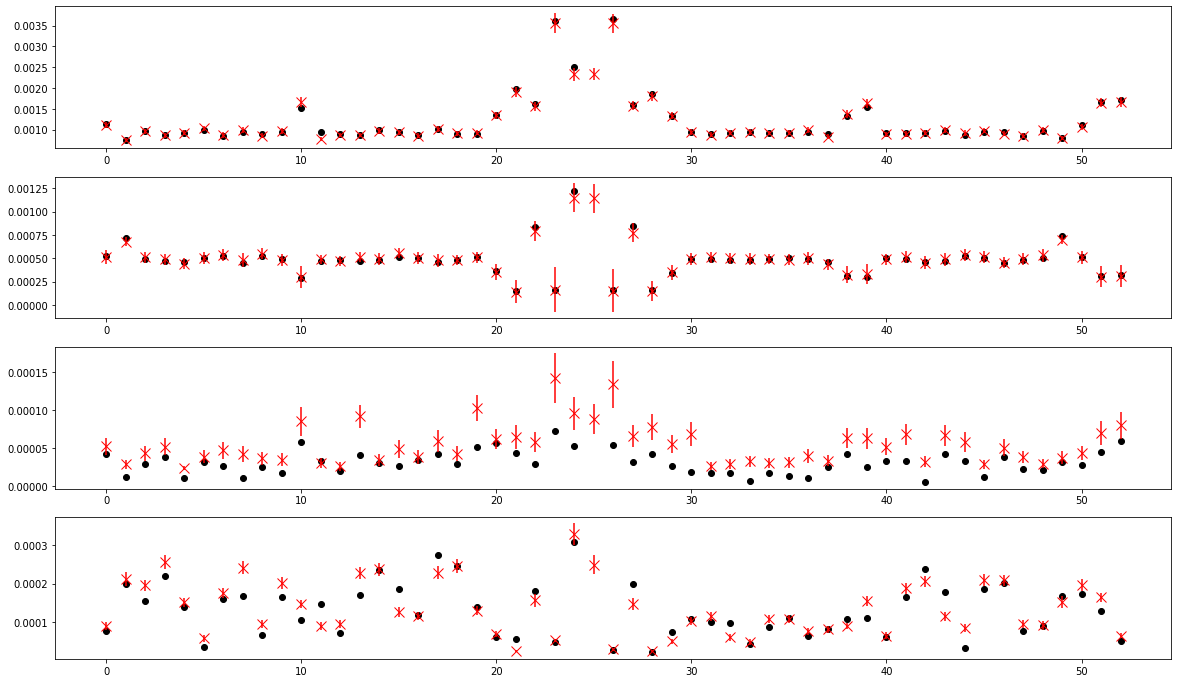

In [55]:
# Coupled beta functions

plt.figure(figsize=(20, 3*4))

ax = plt.subplot(411)
ax.errorbar(range(model.monitor_count), axx.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

ax = plt.subplot(412)
ax.errorbar(range(model.monitor_count), ayy.cpu().numpy(), yerr=sigma_axx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n33**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')

ax = plt.subplot(413)
ax.errorbar(range(model.monitor_count), axy.cpu().numpy(), yerr=sigma_axy.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n13**2 + value_n14**2)*2*twiss.action['center_jy']).sqrt(), color='black', marker='o')

ax = plt.subplot(414)
ax.errorbar(range(model.monitor_count), ayx.cpu().numpy(), yerr=sigma_ayx.cpu().numpy(), fmt=' ', ms=10, color='red', marker='x')
ax.scatter(range(model.monitor_count), ((value_n31**2 + value_n14**2*value_n33**2/value_n11**2)*2*twiss.action['center_jx']).sqrt(), color='black', marker='o')

plt.show()

In [56]:
# RESULTS #

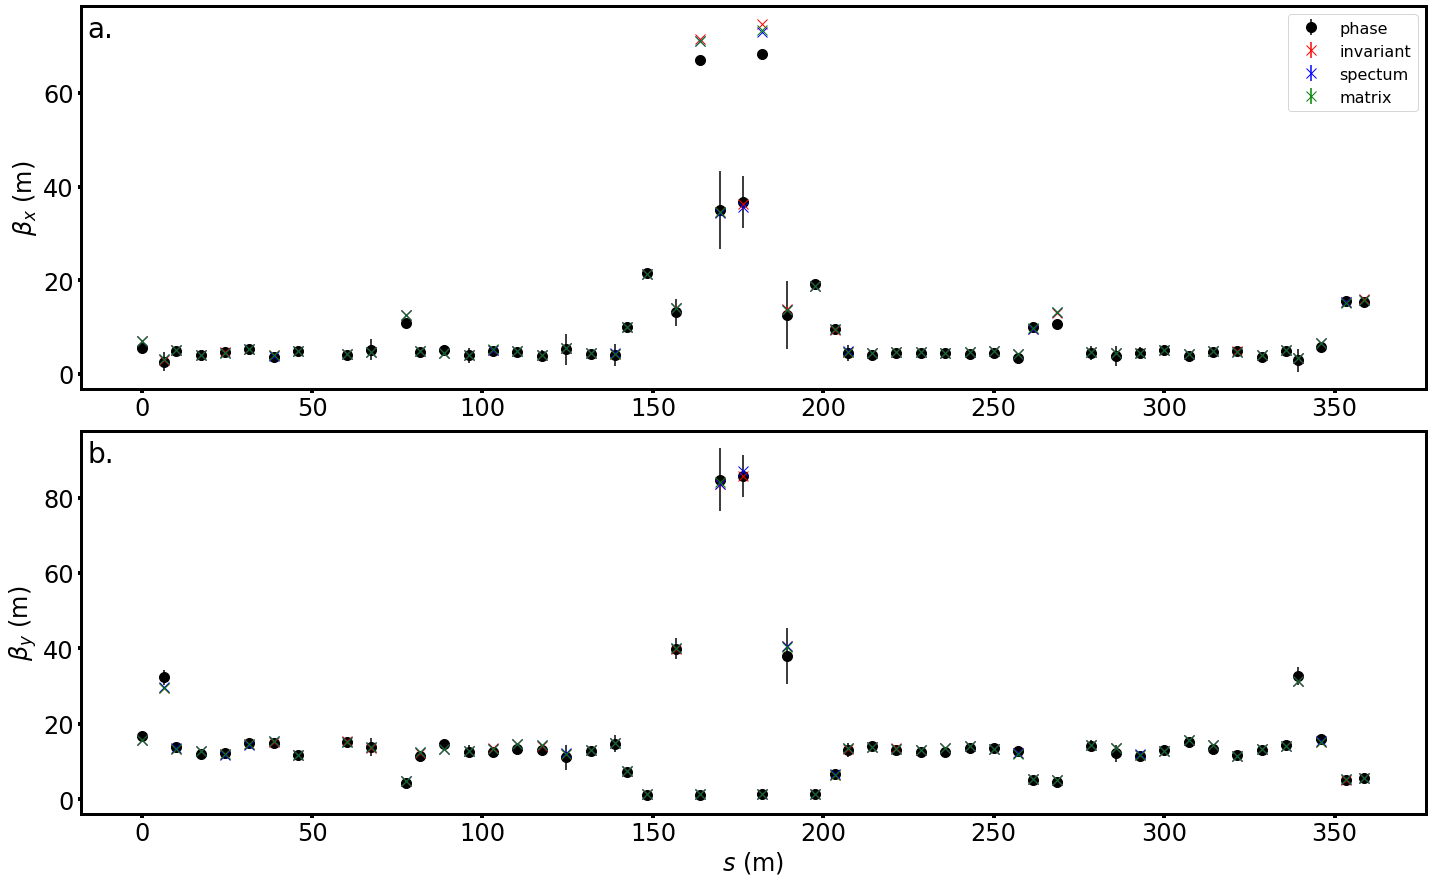

In [57]:
# FIG 

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='black', label='phase')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v1_bx.cpu().numpy(), yerr=e1_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='invariant')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v2_bx.cpu().numpy(), yerr=e2_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue', label='spectum')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v3_bx.cpu().numpy(), yerr=e3_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='green', label='matrix')
ax.tick_params(width=4, labelsize=24)
ax.set_ylabel(r'$\beta_x$ (m)', fontsize=24)
ax.legend(loc=1, prop={'size': 16})

plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()


ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', ms=10, marker='o', color='black', label='phase')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v1_by.cpu().numpy(), yerr=e1_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='red', label='invariant')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v2_by.cpu().numpy(), yerr=e2_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='blue', label='spectum')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), v3_by.cpu().numpy(), yerr=e3_by.cpu().numpy(), fmt=' ', ms=10, marker='x', color='green', label='matrix')
ax.tick_params(width=4, labelsize=24)
ax.set_ylabel(r'$\beta_y$ (m)', fontsize=24)

ax.set_xlabel('$s$ (m)', fontsize=24)

plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("08_twiss_comparison.png", format="png", dpi=300)

plt.show()

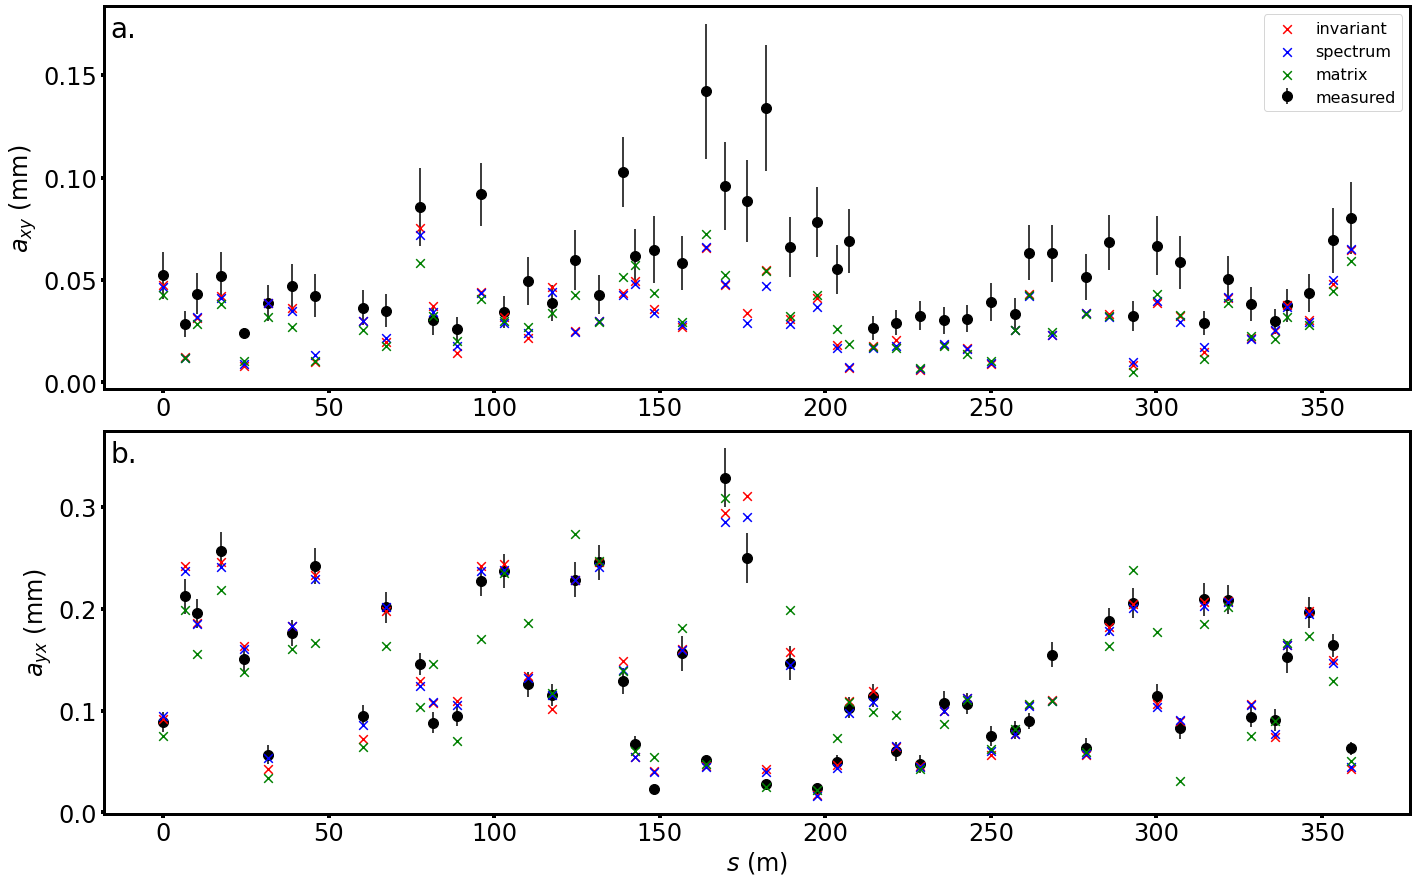

In [58]:
# FIG

# Coupled amplitudes

plt.figure(figsize=(20, 20/((1 + 5**0.5)/2)))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), 1000*axy.cpu().numpy(), yerr=1000*sigma_axy.cpu().numpy(), fmt=' ', ms=10, color='black', marker='o', label='measured', zorder=0)
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v1_n13**2 + v1_n14**2)*2*twiss.action['center_jy']).sqrt(), color='red', marker='x', s=75, label='invariant')
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v2_n13**2 + v2_n14**2)*2*twiss.action['center_jy']).sqrt(), color='blue', marker='x', s=75,label='spectrum')
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v3_n13**2 + v3_n14**2)*2*twiss.action['center_jy']).sqrt(), color='green', marker='x', s=75,label='matrix')
ax.set_ylabel(r'$a_{xy}$ (mm)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.legend(loc=1, prop={'size': 16})


plt.text(0.015, 0.94, 'a.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()


ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(),  1000*ayx.cpu().numpy(), yerr=1000*sigma_ayx.cpu().numpy(), fmt=' ', ms=10, color='black', marker='o', zorder=0)
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v1_n31**2 + v1_n14**2*v1_n33**2/v1_n11**2)*2*twiss.action['center_jx']).sqrt(), color='red', s=75,marker='x')
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v2_n31**2 + v2_n14**2*v2_n33**2/v2_n11**2)*2*twiss.action['center_jx']).sqrt(), color='blue', s=75,marker='x')
ax.scatter(model.time[model.monitor_index].cpu().numpy(),  1000*((v3_n31**2 + v3_n14**2*v3_n33**2/v3_n11**2)*2*twiss.action['center_jx']).sqrt(), color='green', s=75,marker='x')
ax.set_ylabel(r'$a_{yx}$ (mm)', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.set_xlabel('$s$ (m)', fontsize=24)

plt.text(0.015, 0.94, 'b.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=28)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("10_coupled_amplitudes.png", format="png", dpi=300)

plt.show()

In [59]:
# Compute orbits

limit = 2
orbit1 = []
for location in range(model.monitor_count):
    orbit1.append(twiss.get_momenta_lstsq(1, 128, location, limit, model.matrix))
orbit1 = torch.stack(orbit1)
print(orbit1.shape)

limit = 2
orbit2 = []
for location in range(model.monitor_count):
    orbit2.append(twiss.get_momenta_lstsq(1, 128, location, limit, twiss.matrix))
orbit2 = torch.stack(orbit2)
print(orbit2.shape)

torch.Size([53, 4, 128])
torch.Size([53, 4, 128])


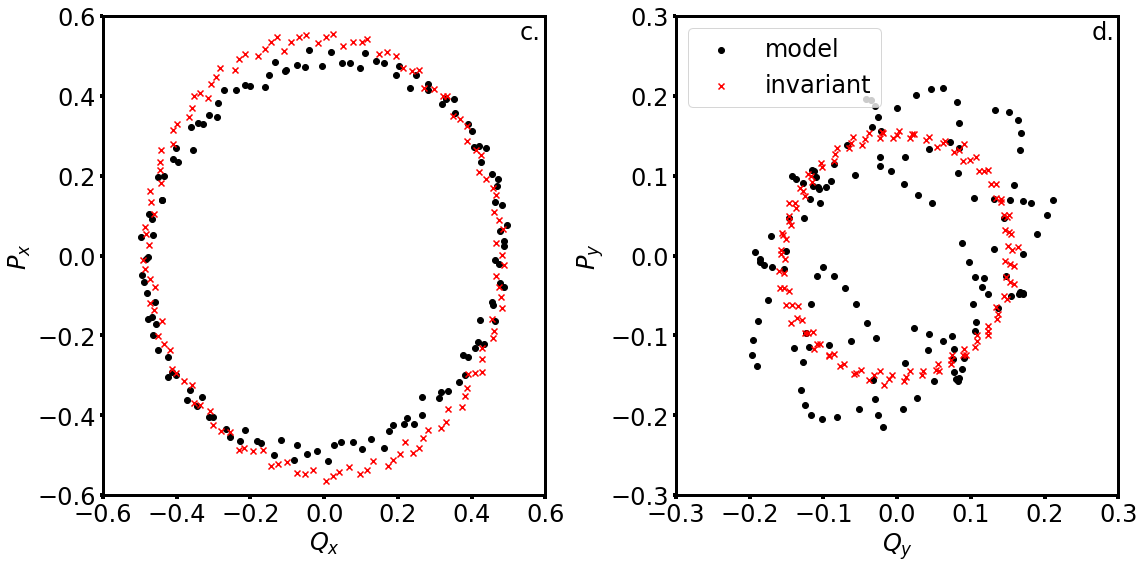

In [60]:
# Plot trajectory

index = 1
select = model.monitor_index[index]

qx1, px1, qy1, py1 = orbit1[index]
Qx1, Px1, Qy1, Py1 = (model.out_normal[select].inverse() @ orbit1[index]).cpu().numpy()

from src.parameterization import cs_normal, parametric_normal

normal = cs_normal(twiss.ax[select], twiss.bx[select], twiss.ay[select], twiss.by[select])

normal = parametric_normal(v1_n11[index], v1_n33[index], v1_n21[index], v1_n43[index], v1_n13[index], v1_n31[index], v1_n14[index], v1_n41[index])

qx2, px2, qy2, py2 = orbit2[index]
Qx2, Px2, Qy2, Py2 = (normal.inverse() @ orbit2[index]).cpu().numpy()


plt.figure(figsize=(2*8, 8))
ax = plt.subplot(121)
ax.scatter(1000*Qx1, 1000*Px1, color='black', marker='o', label='model')
ax.scatter(1000*Qx2, 1000*Px2, color='red', marker='x', label='invariant')
ax.set_xlabel(r'$Q_x$', fontsize=24)
ax.set_ylabel(r'$P_x$', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)

plt.text(0.965, 0.965, 'c.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

ax = plt.subplot(122)
ax.scatter(1000*Qy1, 1000*Py1, color='black', marker='o', label='model')
ax.scatter(1000*Qy2, 1000*Py2, color='red', marker='x', label='invariant')
ax.set_xlabel(r'$Q_y$', fontsize=24)
ax.set_ylabel(r'$P_y$', fontsize=24)
ax.tick_params(width=4, labelsize=24)
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.legend(loc=2, prop={'size': 24})

plt.text(0.965, 0.965, 'd.',horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=24)
plt.setp(ax.spines.values(), linewidth=3.0)
plt.tight_layout()

if SAVE:
    plt.savefig("09_coupled_normalization.png", format="png", dpi=300)

plt.show()